In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

# Helper functions

In [5]:
import matplotlib 
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points


def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if dataset_name == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            if datasets == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        df["num_evaluations"] = len(df.fitness.apply(literal_eval).apply(np.array)[0])*60
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
        
        df["gini_index"] = get_gini_coefficients(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.gini_index)
        df["gini_mean"] = mean_f0
        df["gini_min"] = min_f0
        df["gini_max"] = max_f0
        
        df["total_drive_time"] = [sum(x)/60 for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time)
        df["total_drive_time_mean"] = mean_f0
        df["total_drive_time_min"] = min_f0
        df["total_drive_time_max"] = max_f0
        #df["longest_route_time_final"] = df["total_drive_time"]
        
#         max_total_time_final = max(df.total_drive_time)
#         min_total_time_final = min(df.total_drive_time)
#         df["total_drive_time_final_minmax"] = (df.total_drive_time - min_total_time_final)/(max_total_time_final - min_total_time_final)
        
#         mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time_final_minmax)
#         df["total_drive_time_final_minmax_mean"] = mean_f0
#         df["total_drive_time_final_minmax_min"] = min_f0
#         df["total_drive_time_final_minmax_max"] = max_f0
        
        
        
        
        
        
        
        df["driver_amount"] = [len(x) for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.driver_amount)
        df["driver_amount_mean"] = mean_f0
        df["driver_amount_min"] = min_f0
        df["driver_amount_max"] = max_f0
        
        df["objective_sum"] = df.fuel_consumption_final + df.longest_route_time_final
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.objective_sum)
        df["objective_sum_mean"] = mean_f0
        df["objective_sum_min"] = min_f0
        df["objective_sum_max"] = max_f0
        
        
        
        
        
    return pd.concat(simulations)



def plot_2d_minmax_scaled(datapoints, labels, show_mean_eval=False, minmax_scale = True,marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Multiobjective":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA-D&C"] = {"color":"#8c564b", "marker":"o"}
    marker_kwargs["IBEA-D&C"] = {"color":"#ff7f0e", "marker":"D"}
    marker_kwargs["NSGA-III-D&C"] = {"color":"#e377c2", "marker":"s"}
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        if minmax_scale:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        else:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max##data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max#
        if "D&C" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
            
        if minmax_scale:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))
        else:
            


            if show_mean_eval:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                         round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                                         int(round(min_f1,0)),int(round(mean_f1,0)),int(round(max_f1,0)), round(data.num_evaluations))
            else:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                             round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                             int(round(min_f1,0)),int(round(mean_f1,0)),int(round(max_f1,0)))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
    return fig, ax
def plot_vehicle_drivetimes2(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)

    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    max_vehicle_amount = vehicle_amounts[-1]
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    plt.xticks(ticks=range(0,max_vehicle_amount),labels=range(1,max_vehicle_amount+1))
    plt.ylabel("Drive Time (minutes)",fontsize=42)
    plt.xlabel("Vehicle nr",fontsize=42)
    plt.legend(fontsize=32)
        
    
    

In [6]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    
    datasets = dataframes[0].dataset.unique()
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()
    
            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    for dataset in datasets:
        for dataframe in dataframes:
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
            dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
            dataframe["fuel_consumption_final_minmax_min"] = min_f0
            dataframe["fuel_consumption_final_minmax_max"] = max_f0

            mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
            dataframe["longest_route_time_final_minmax_mean"] = mean_f0
            dataframe["longest_route_time_final_minmax_min"] = min_f0
            dataframe["longest_route_time_final_minmax_max"] = max_f0


In [7]:
def add_minmax_fuel_drivetime_columns(dataframes,datasets = None):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    if datasets == None:
        datasets = dataframes[0].dataset.unique()
        
    for dataset in datasets:
        if not dataset in max_fuel_consumptions.keys():
            max_fuel_consumptions[dataset] = 0
            min_fuel_consumptions[dataset]  = 10e10
            max_drivetimes[dataset]  = 0
            min_drivetimes[dataset]  = 10e10
        for dataframe in dataframes:

            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()

            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()

            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel

            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel

            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime

            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
    for dataframe in dataframes:
        fuel_minmax = []  
        longest_minmax = []
        
        for dataset in datasets:
       
        
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = np.array((dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption))
            fuel_minmax.extend(dataframe_fuel_consumption_scaled[np.where(dataframe.dataset == dataset)])
            
            dataframe_longest_drivetime_scaled = np.array((dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final))
            longest_minmax.extend(dataframe_longest_drivetime_scaled[np.where(dataframe.dataset == dataset)])

      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(fuel_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(longest_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0




In [8]:
import time 
start_time = time.monotonic()

print("SA")
SA_data_time_limited = combine_datasets("SA", "time_limited_test_data/")
print("GA")
GA_data_time_limited = combine_datasets("GA", "time_limited_test_data/")
print("NSGA2")
NSGA2_data_time_limited = combine_datasets("NSGA2", "time_limited_test_data/")
print("NSGA3")
NSGA3_data_time_limited = combine_datasets("NSGA3", "time_limited_test_data/")
print("UNSGA3")
UNSGA3_data_time_limited = combine_datasets("UNSGA3", "time_limited_test_data/")
print("IBEA")
IBEA_data_time_limited = combine_datasets("IBEA", "time_limited_test_data/")

add_minmax_fuel_drivetime_columns([SA_data_time_limited,GA_data_time_limited,
                                   NSGA2_data_time_limited,NSGA3_data_time_limited,
                                   UNSGA3_data_time_limited,IBEA_data_time_limited])

SA_data_time_limited_mean = SA_data_time_limited.mean()
GA_data_time_limited_mean = GA_data_time_limited.mean()
NSGA2_data_time_limited_mean = NSGA2_data_time_limited.mean()
NSGA3_data_time_limited_mean = NSGA3_data_time_limited.mean()
UNSGA3_data_time_limited_mean = UNSGA3_data_time_limited.mean()
IBEA_data_time_limited_mean = IBEA_data_time_limited.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  3.4147459139967395


In [9]:
import time 
start_time = time.monotonic()
print("SA")
SA_data_evaluation_limited = combine_datasets("SA", "parameter_data/reruns/")
#SA_data_evaluation_limited = SA_data_evaluation_limited.where(SA_data_evaluation_limited["Parameter Group"] == 4).dropna()
print("GA")
GA_data_evaluation_limited = combine_datasets("GA", "parameter_data/reruns/")
#GA_data_evaluation_limited = GA_data_evaluation_limited.where(GA_data_evaluation_limited["Parameter Group"] == 38).dropna()
print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/reruns_L1/")
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/reruns_L1/")
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/reruns_L1/")
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/reruns_L1/")
add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited,GA_data_evaluation_limited,
                                   NSGA2_data_evaluation_limited,NSGA3_data_evaluation_limited,
                                   UNSGA3_data_evaluation_limited,IBEA_data_evaluation_limited])
SA_data_evaluation_limited_mean = SA_data_evaluation_limited.mean()
GA_data_evaluation_limited_mean = GA_data_evaluation_limited.mean()
NSGA2_data_evaluation_limited_mean = NSGA2_data_evaluation_limited.mean()
NSGA3_data_evaluation_limited_mean = NSGA3_data_evaluation_limited.mean()
UNSGA3_data_evaluation_limited_mean = UNSGA3_data_evaluation_limited.mean()
IBEA_data_evaluation_limited_mean = IBEA_data_evaluation_limited.mean()
print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  3.8602635739989637


In [95]:
ibea_data_2 = pd.read_csv("parameter_data/reruns_L1/UK50_2/IBEA_gini_third_objective_total_drivetime_factor_2.csv")
add_final_fitness_columns(ibea_data_2)
print(ibea_data_2.mean())
ibea_data_2["dataset"] = "UK50_2"

plot_vehicle_drivetimes

Unnamed: 0                   14.500000
fuel_consumption_final      178.911998
longest_route_time_final    276.591667
dtype: float64


NameError: name 'plot_vehicle_drivetimes' is not defined

In [ ]:
plot_vehicle_drivetimes(ibea_data_2,"UK50_2")

In [ ]:
ibea_data_2 = pd.read_csv("parameter_data/reruns_L1/UK50_1/IBEA_gini_third_objective_total_drivetime_factor_2.csv")
add_final_fitness_columns(ibea_data_2)
ibea_data_2["dataset"] = "UK50_1"
print("Gini mean ",np.mean(get_gini_coefficients(ibea_data_2)))
ibea_data_2.mean()


In [ ]:
ibea_data_2 = pd.read_csv("parameter_data/reruns_L1/UK50_1/IBEA_gini_third_objective_total_drivetime.csv")
add_final_fitness_columns(ibea_data_2)
print("Gini mean ",np.mean(get_gini_coefficients(ibea_data_2)))
ibea_data_2["dataset"] = "UK50_1"
ibea_data_2.mean()

# Plot Time limited to 5s

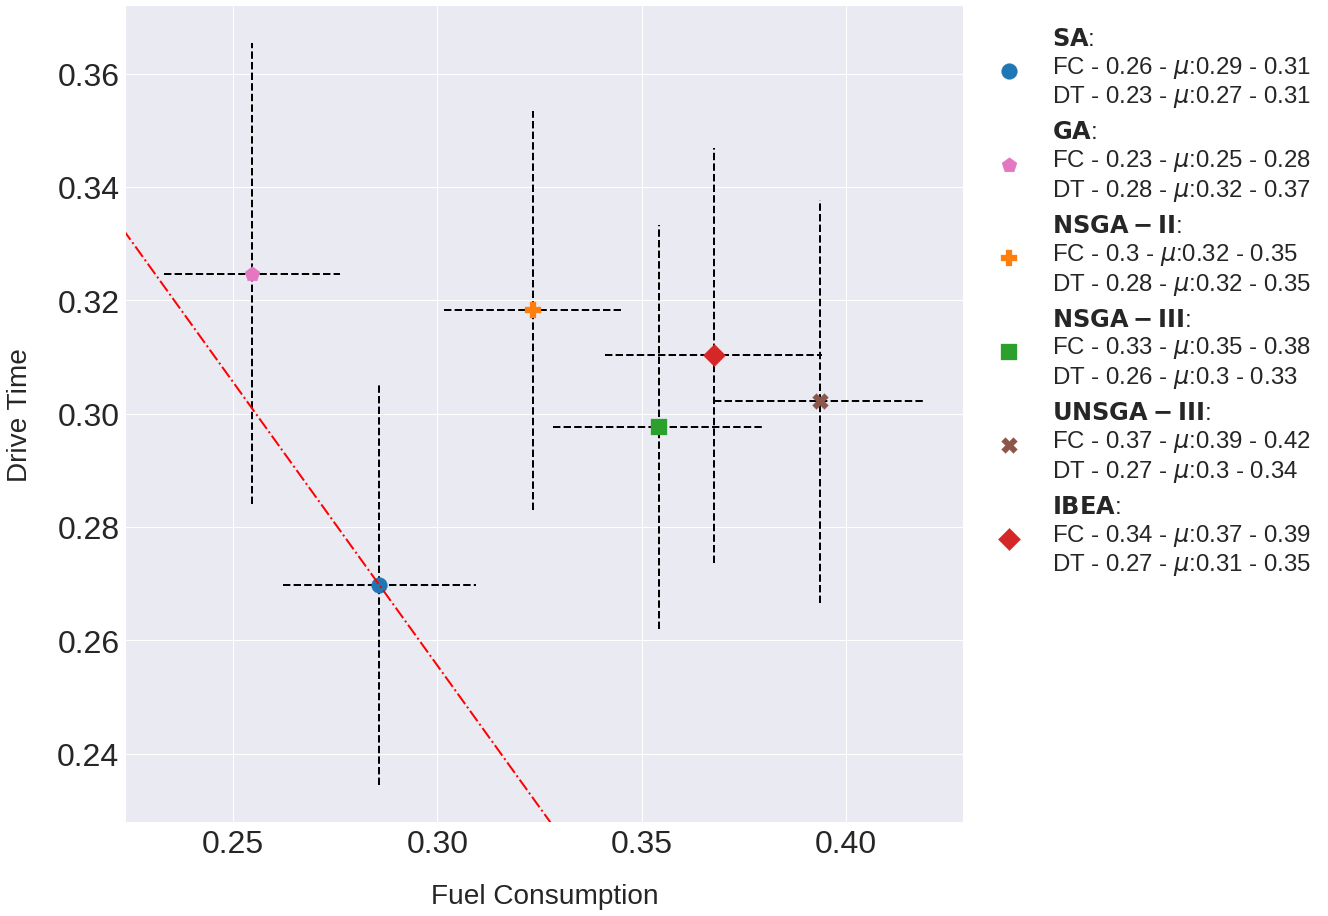

In [60]:
algorithms = [SA_data_time_limited_mean, GA_data_time_limited_mean, NSGA2_data_time_limited_mean, NSGA3_data_time_limited_mean, UNSGA3_data_time_limited_mean, IBEA_data_time_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=True)
plt.legend(bbox_to_anchor=(1, 1))

x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
point_1,point_2 = get_pareto_line_minmax(algorithms,plt.xlim(),plt.ylim()) 


points = np.array([point_1,point_2])

plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
ax.set_ylim(y0,y1)
ax.set_xlim(x0,x1)
#ax.set_xticklabels([np.round(x,2) for x in ax.get_xticks()])


ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format("combined"),bbox_inches='tight')
plt.show()

In [11]:
fig.savefig("{}/confidence_plot_2d_5s_time_limited.pdf".format(imgs_path), bbox_inches='tight')

# Plot Time limited to 5s for all datasets

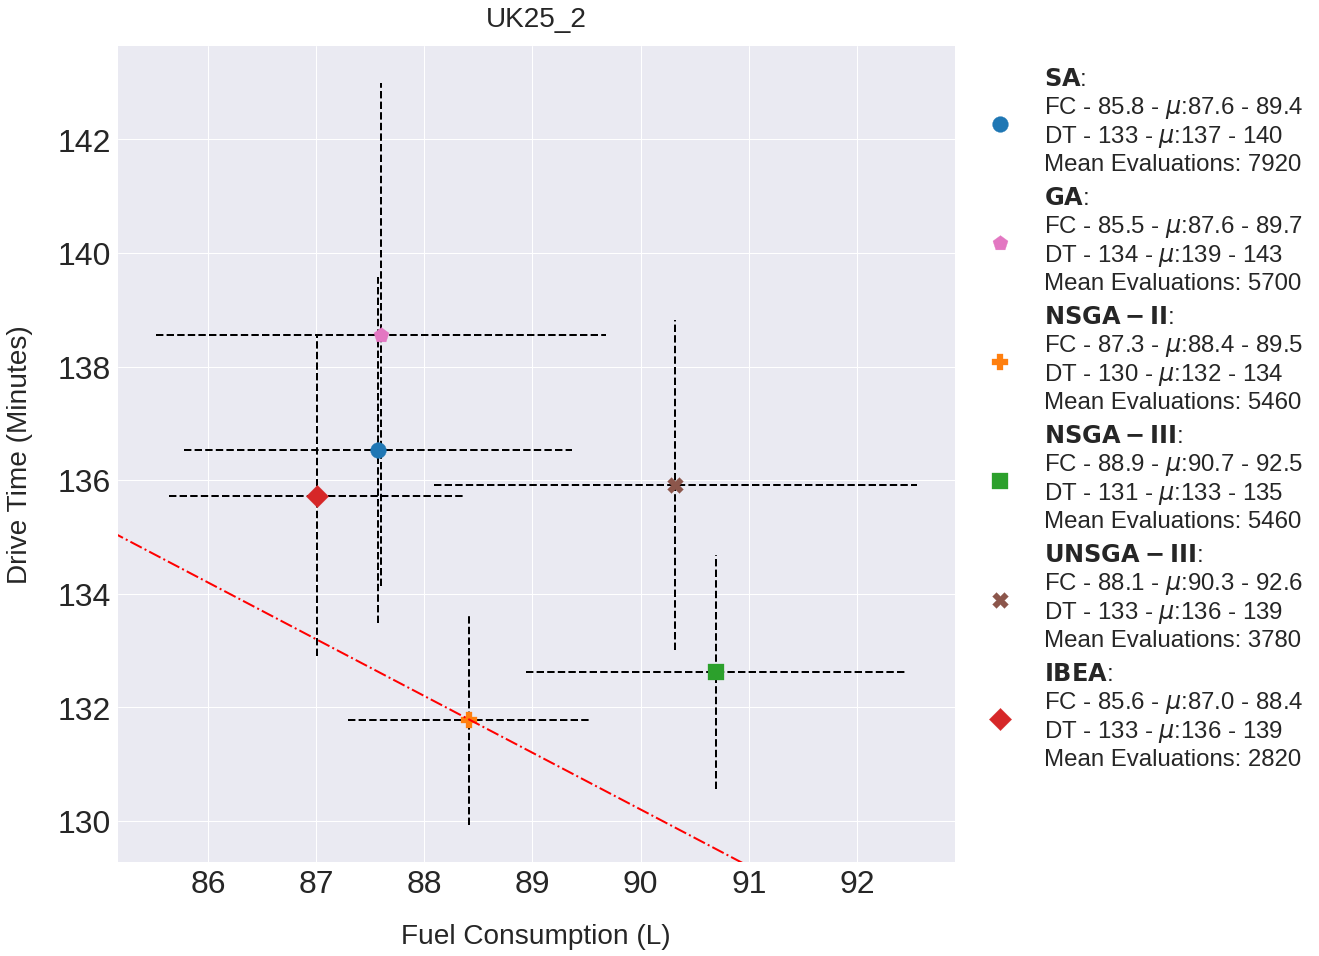

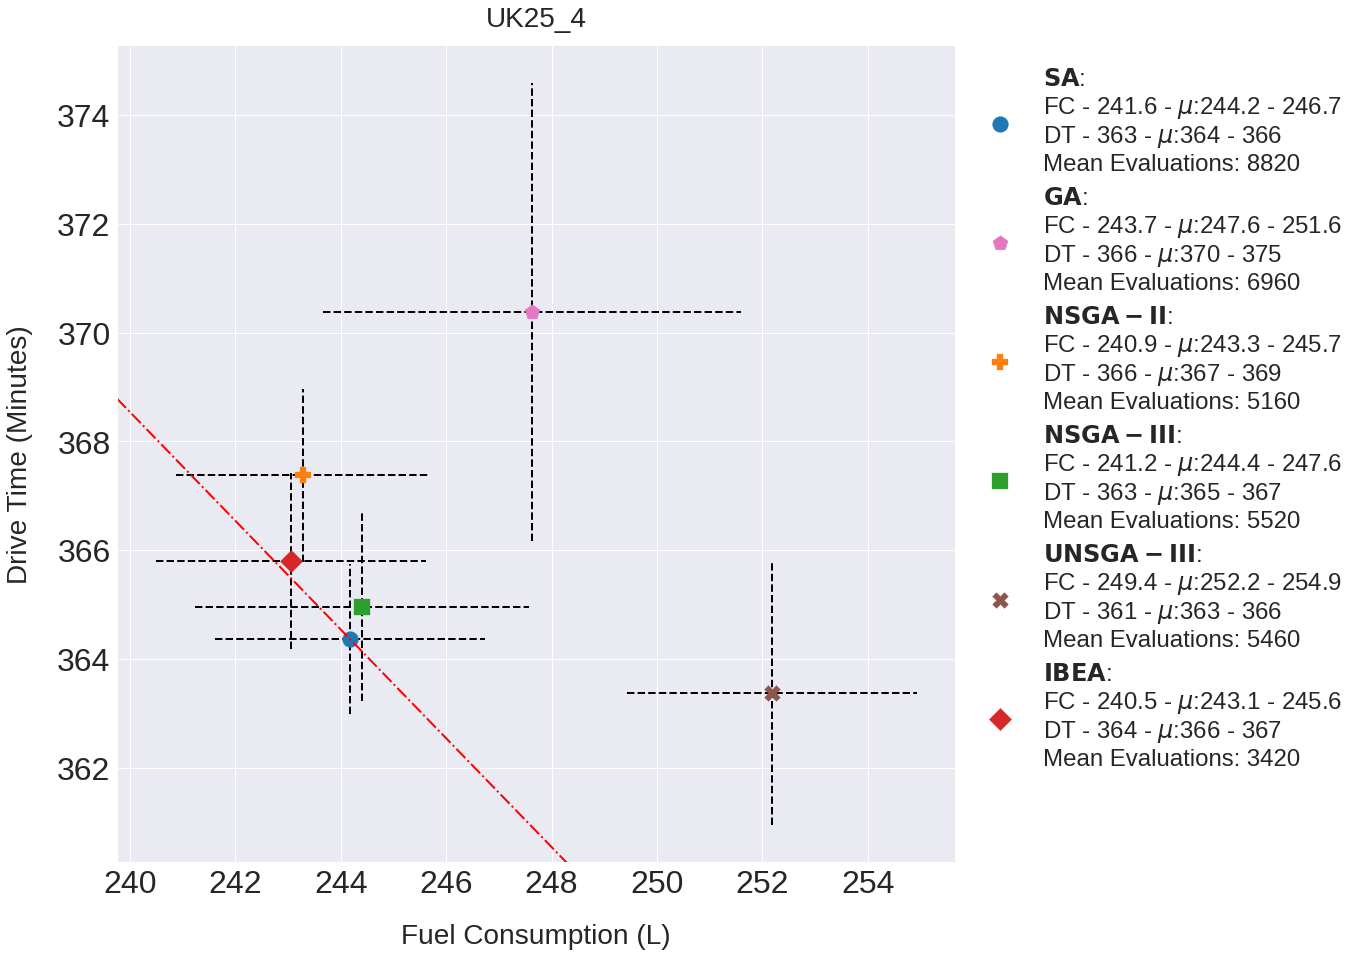

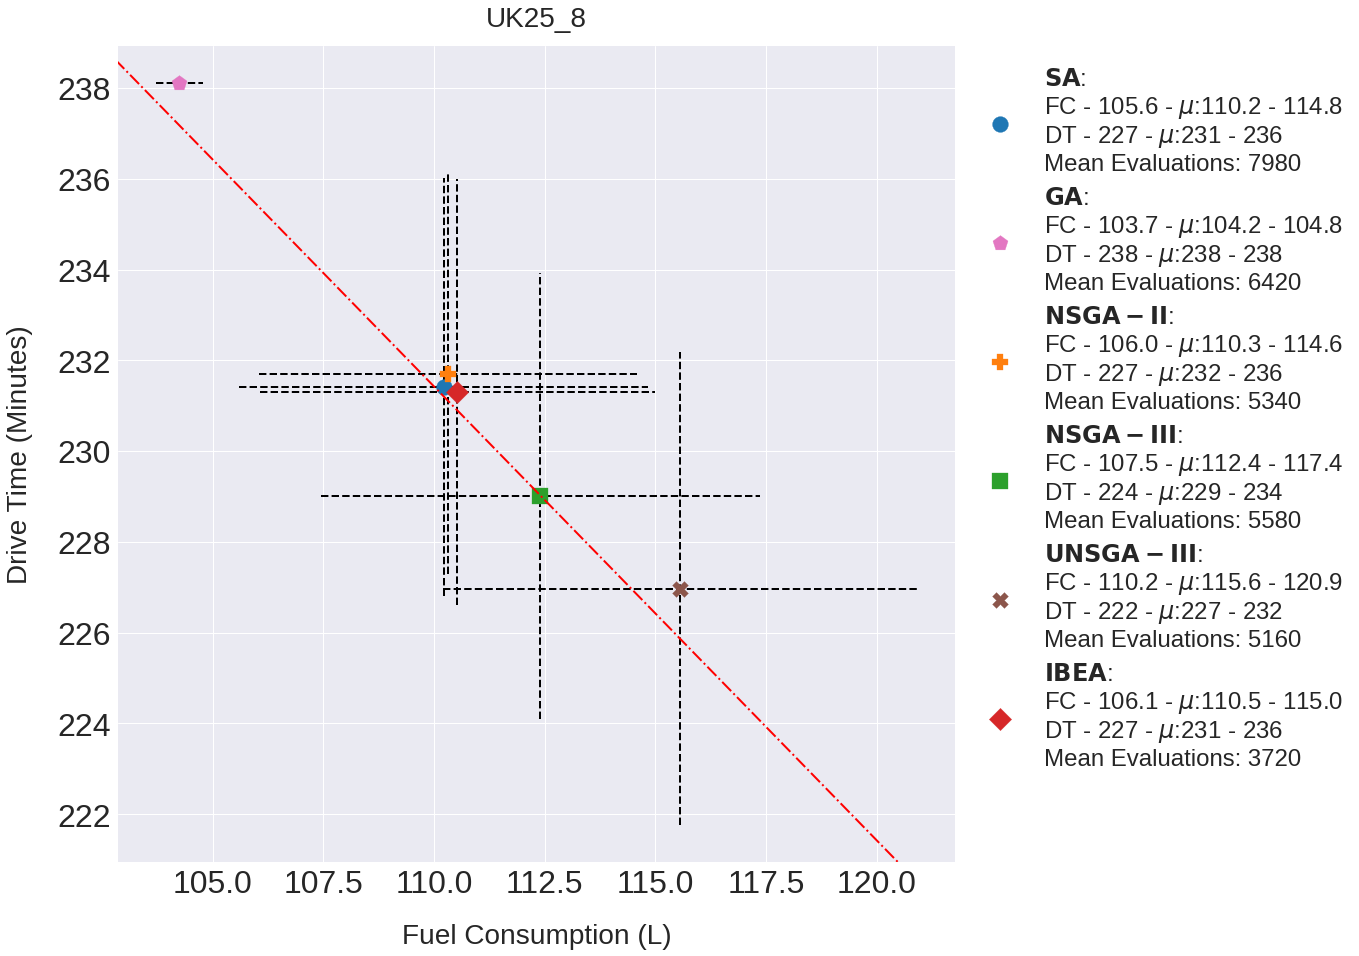

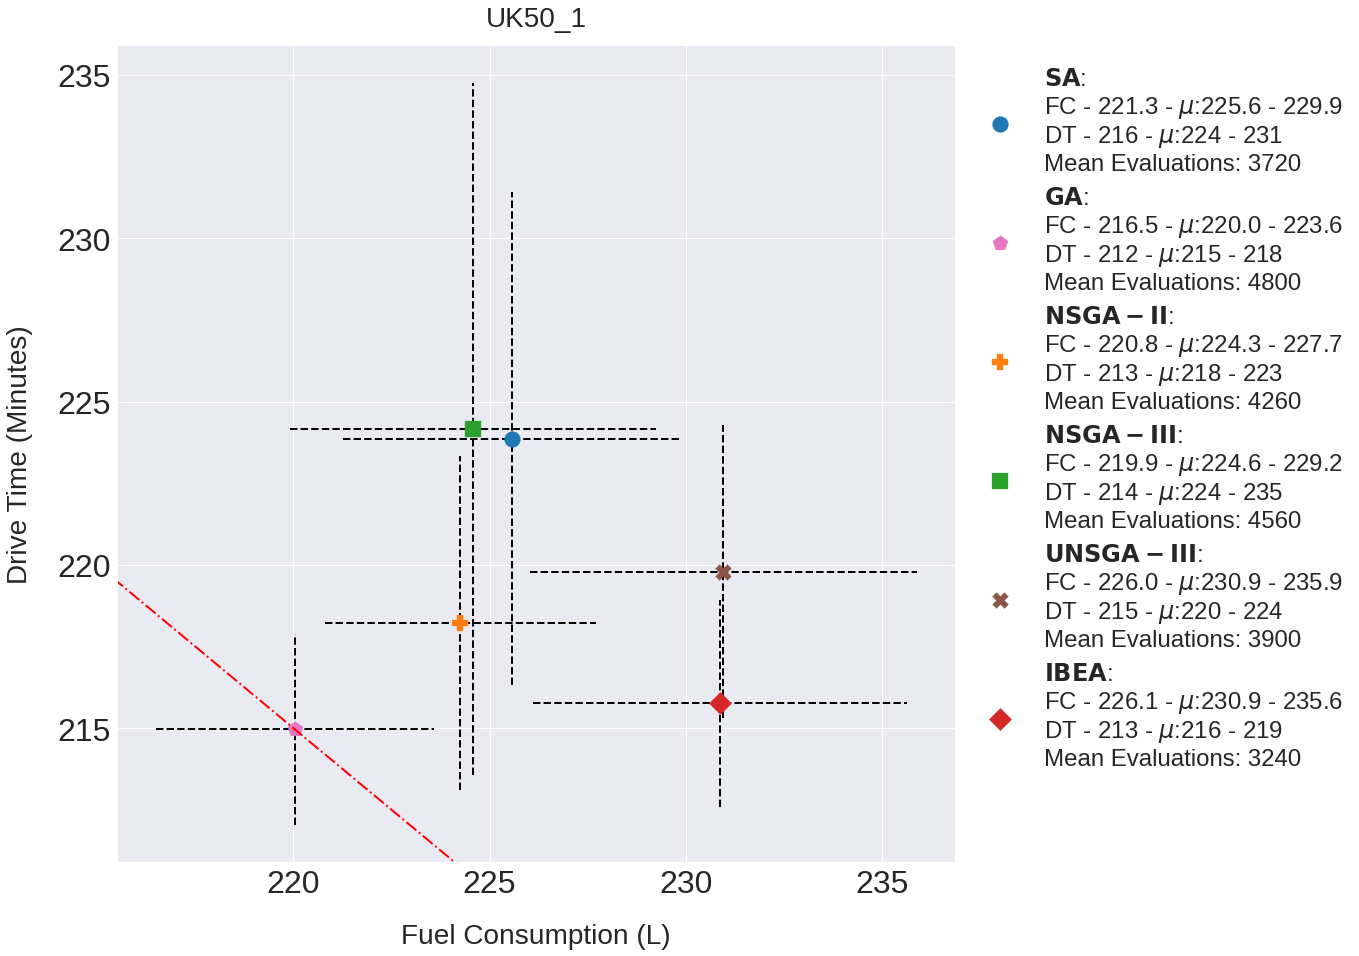

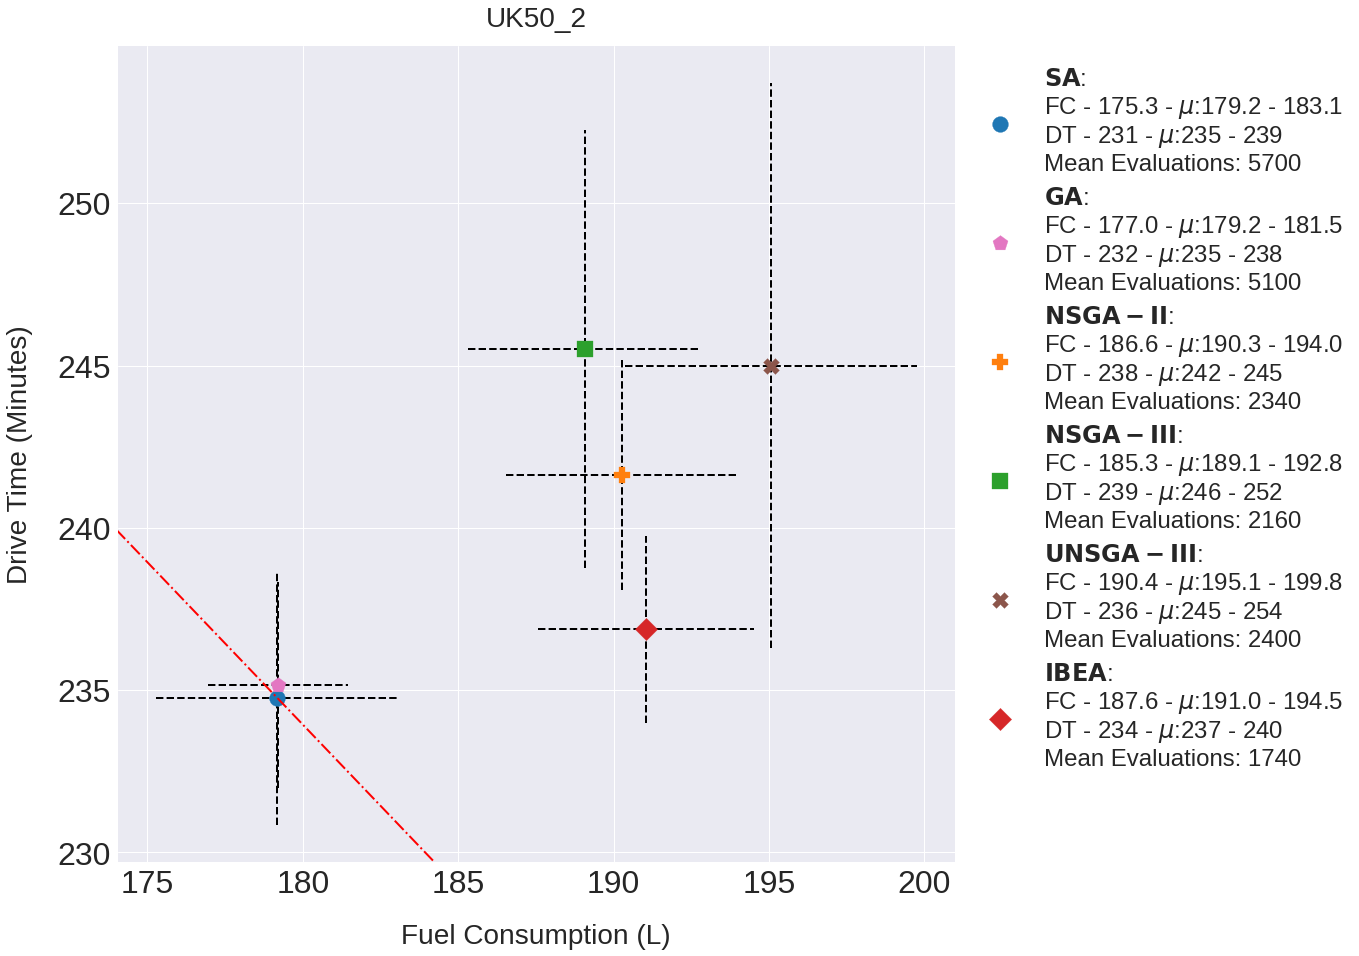

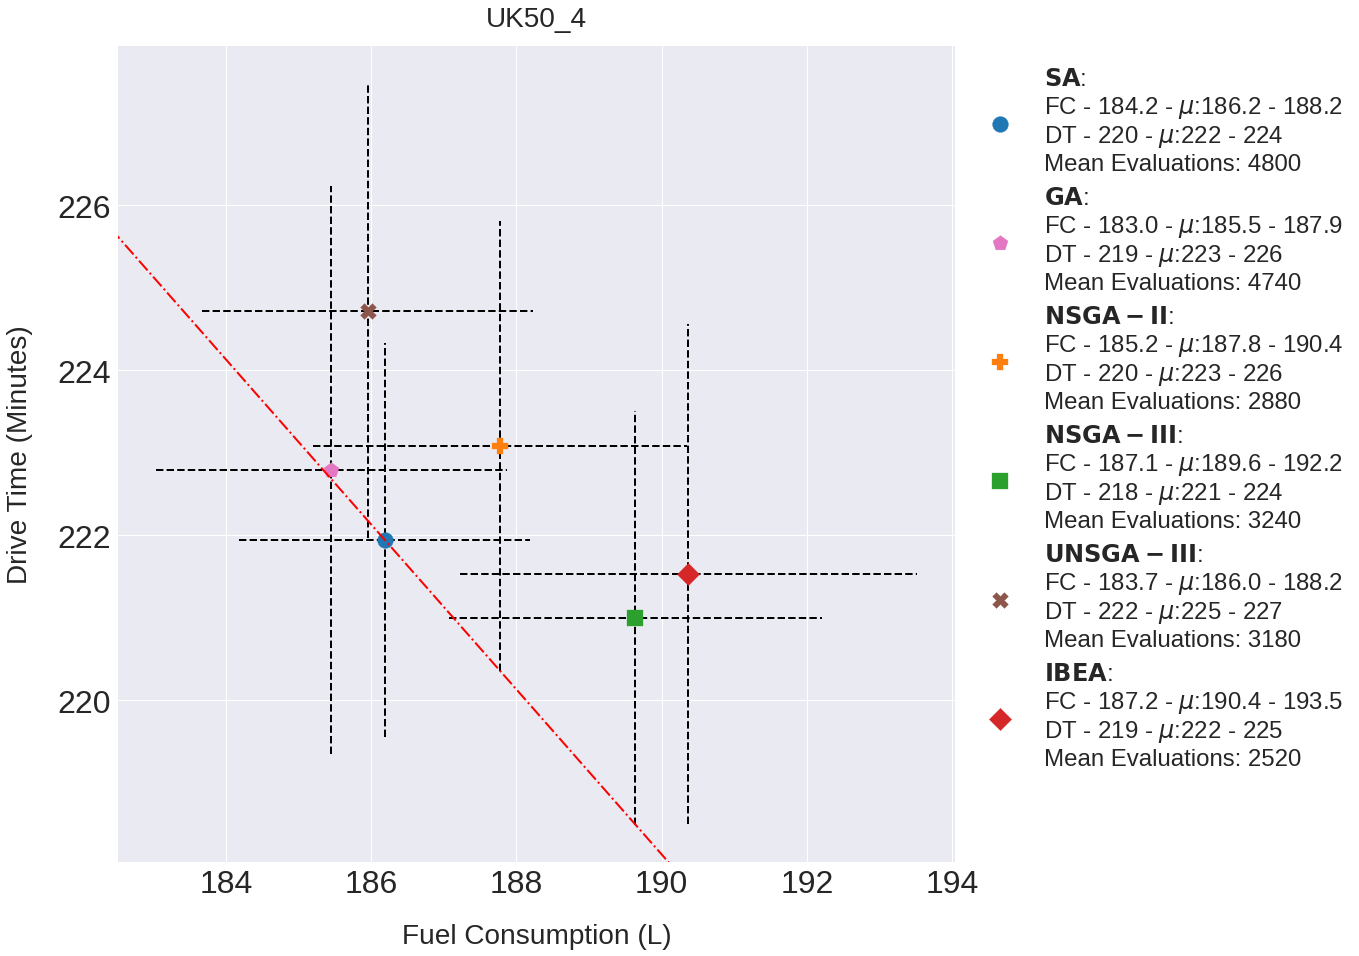

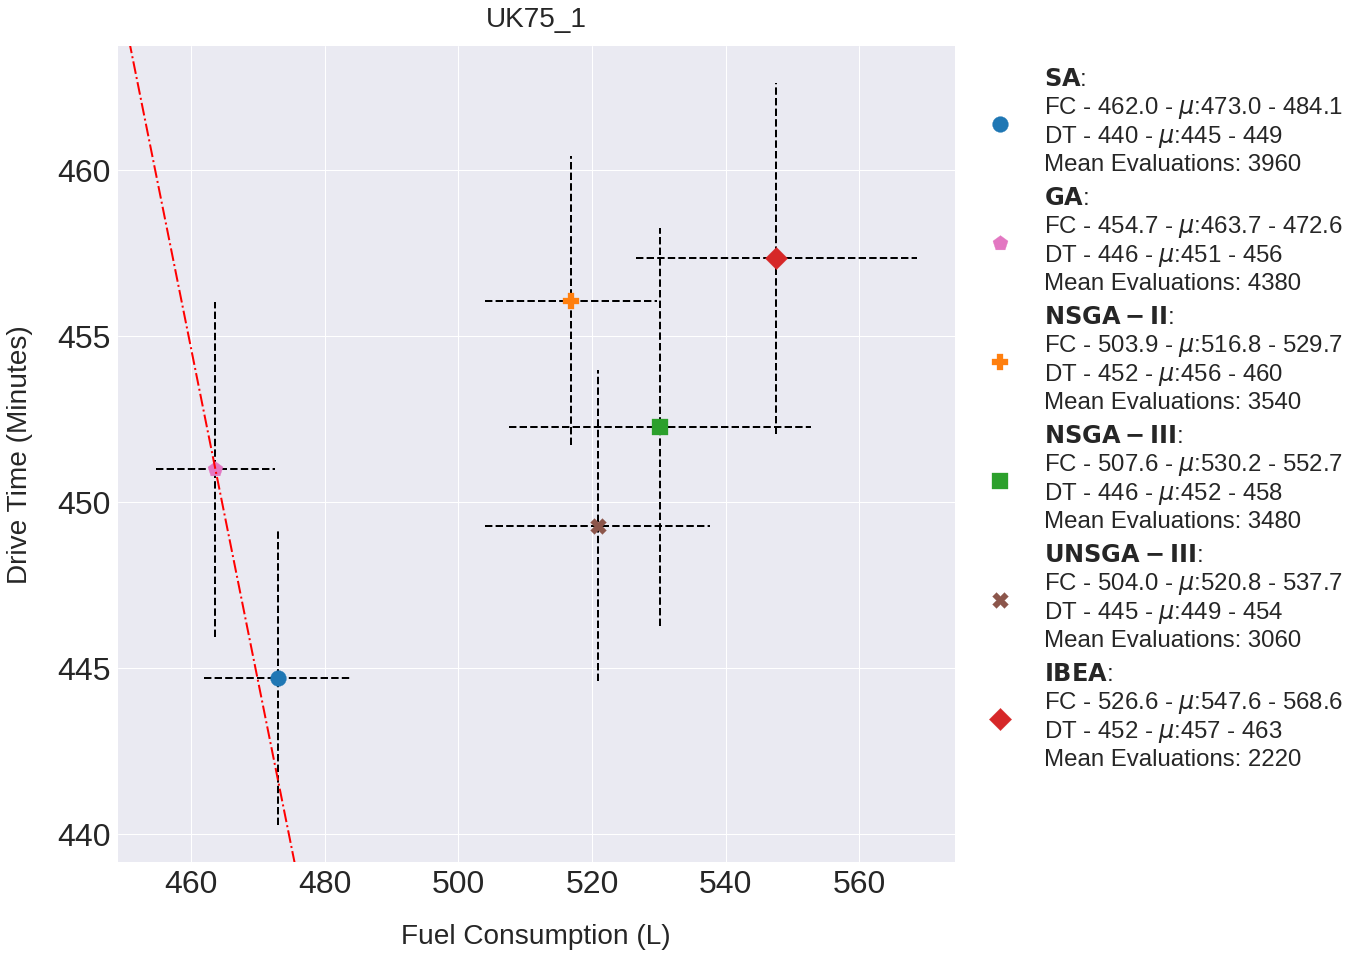

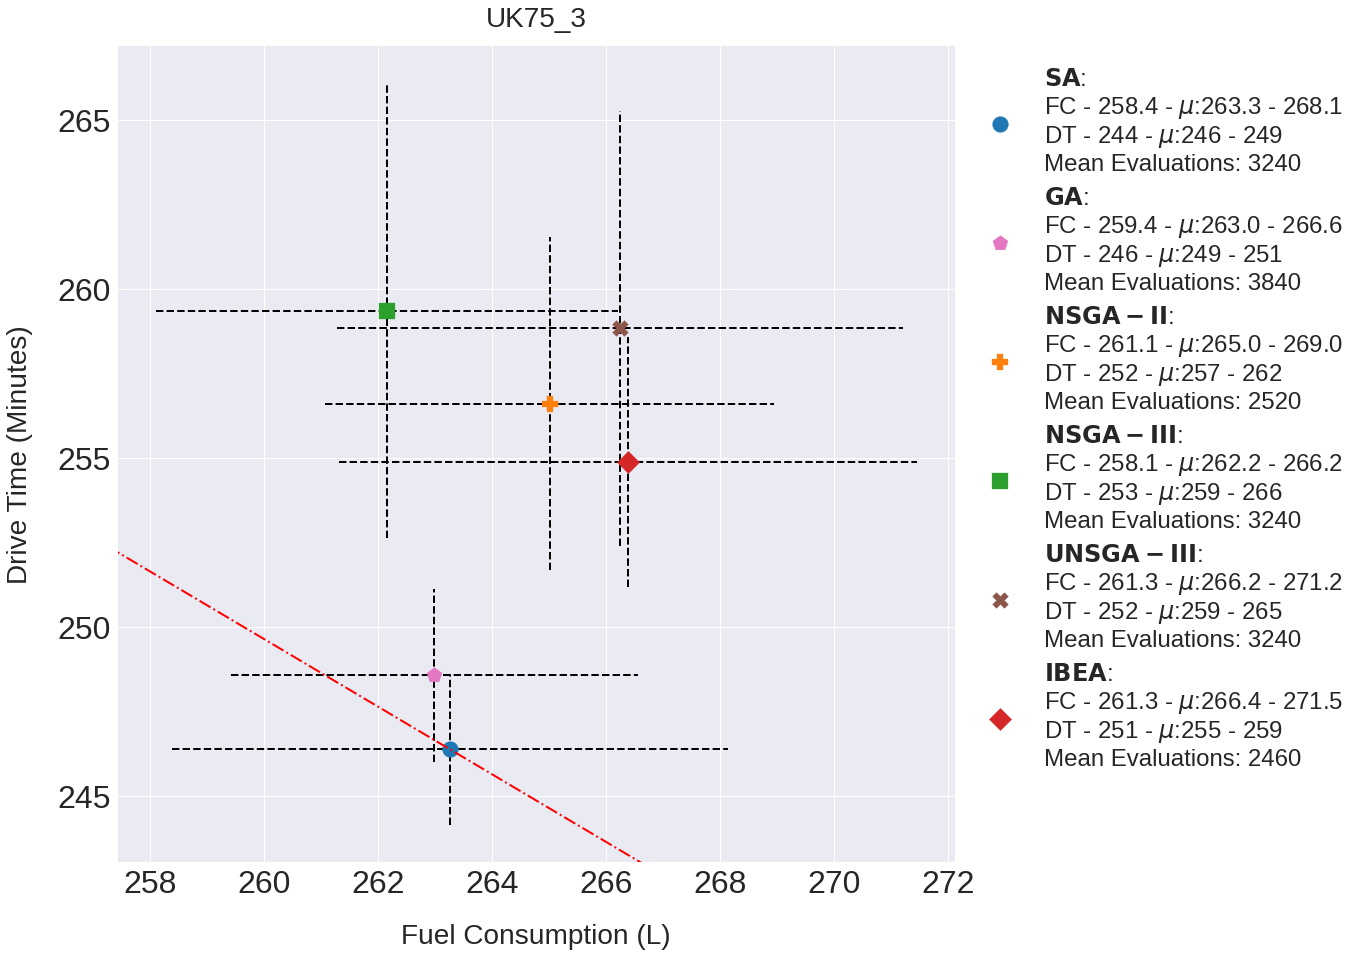

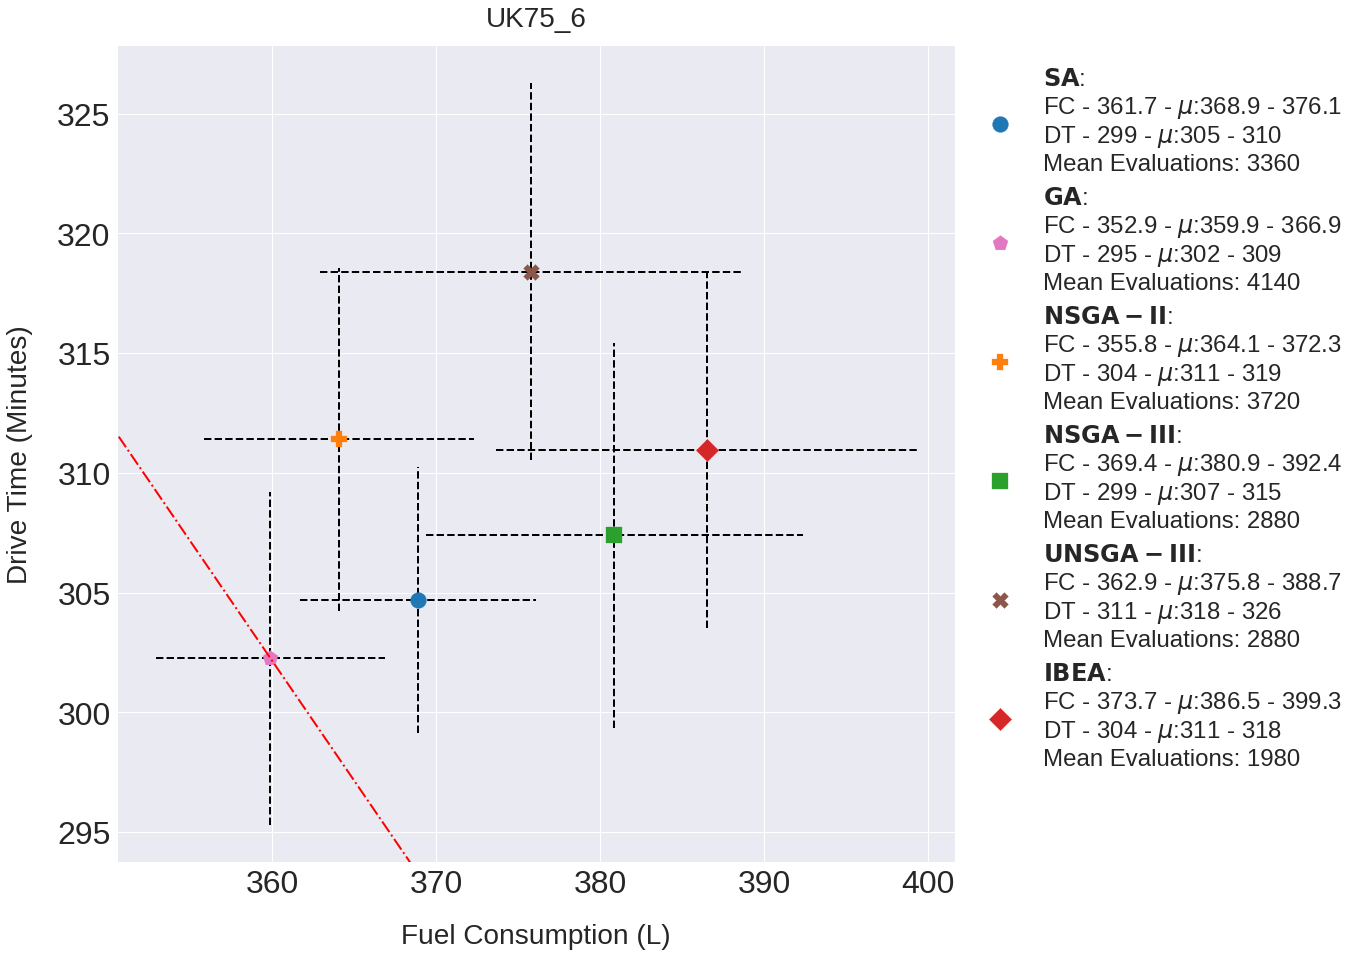

In [29]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False,show_mean_eval=True)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()

# Plot evaluation limited

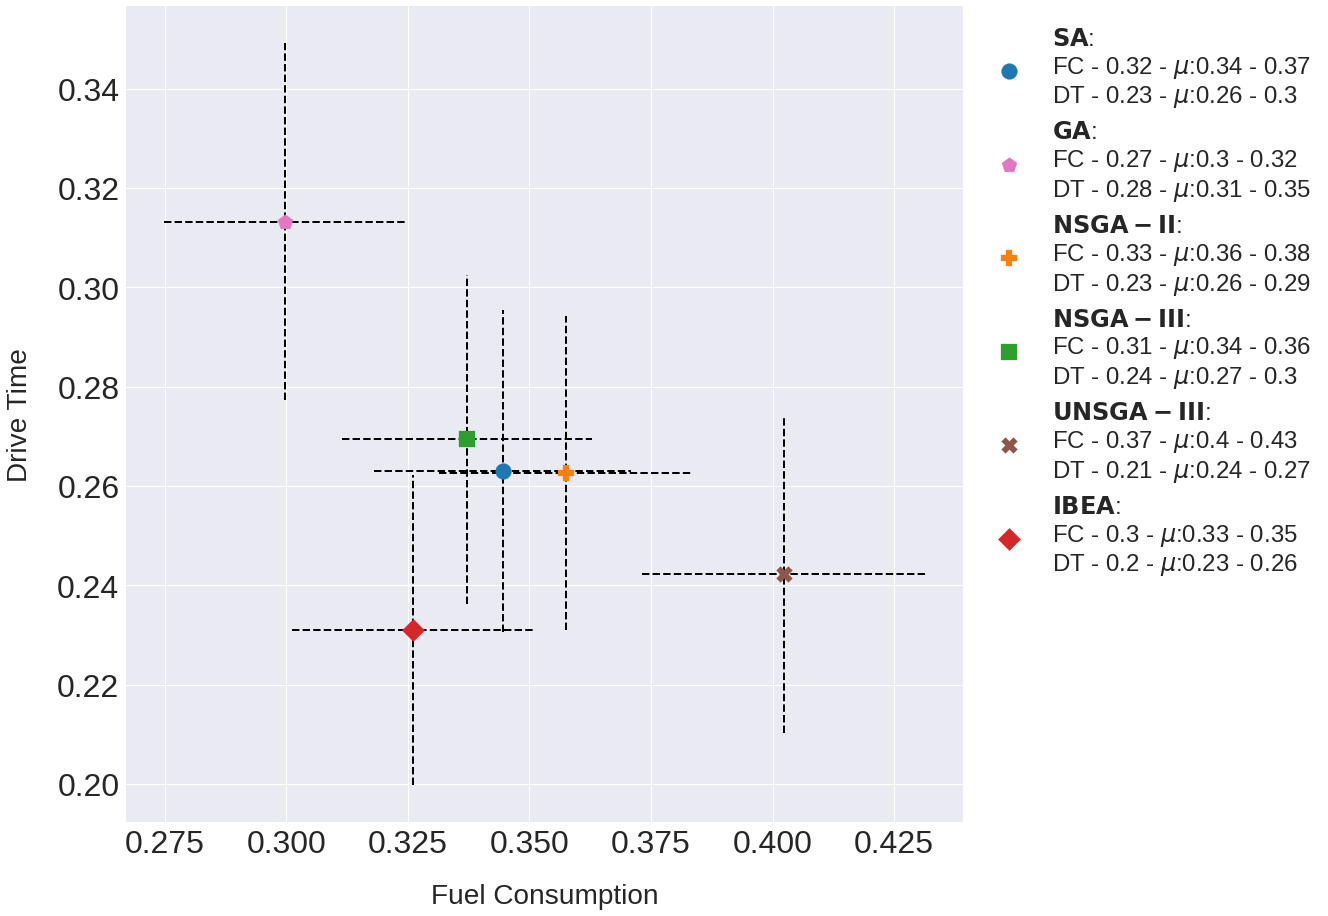

In [87]:
algorithms = [SA_data_evaluation_limited_mean, GA_data_evaluation_limited_mean, NSGA2_data_evaluation_limited_mean, NSGA3_data_evaluation_limited_mean, UNSGA3_data_evaluation_limited_mean, IBEA_data_evaluation_limited_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format("combined"),bbox_inches='tight')
#plt.tight_layout(pad=2)
plt.show()

# Plot evaluation limited for all datasets

In [118]:
# IBEA_data_third_objective = combine_datasets("IBEA_gini_third_objective_total_drivetime", "parameter_data/reruns_L1/")
# #IBEA_data_evaluation_limited = combine_datasets("IBEA_gini_second_objective", "parameter_data/reruns_L1/")



# add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited,GA_data_evaluation_limited,
#                                    NSGA2_data_evaluation_limited,NSGA3_data_evaluation_limited,
#                                    UNSGA3_data_evaluation_limited,IBEA_data_evaluation_limited,IBEA_data_third_objective])
# IBEA_data_third_objective_mean = IBEA_data_third_objective.mean()
# SA_data_evaluation_limited_mean = SA_data_evaluation_limited.mean()
# GA_data_evaluation_limited_mean = GA_data_evaluation_limited.mean()
# NSGA2_data_evaluation_limited_mean = NSGA2_data_evaluation_limited.mean()
# NSGA3_data_evaluation_limited_mean = NSGA3_data_evaluation_limited.mean()
# UNSGA3_data_evaluation_limited_mean = UNSGA3_data_evaluation_limited.mean()
# IBEA_data_evaluation_limited_mean = IBEA_data_evaluation_limited.mean()

In [100]:
IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == "UK25_2").dropna(how="all").sort_values(by="distance_to_origin").head(1).paths.iloc[0]

"[['V0', 14, 9, 24, 13, 7, 23, 22], ['V4', 1, 21, 8, 19, 20], ['V5', 25, 11, 18, 3, 16, 12, 17, 4]]"

<ipython-input-12-9ed2b4bb8272>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



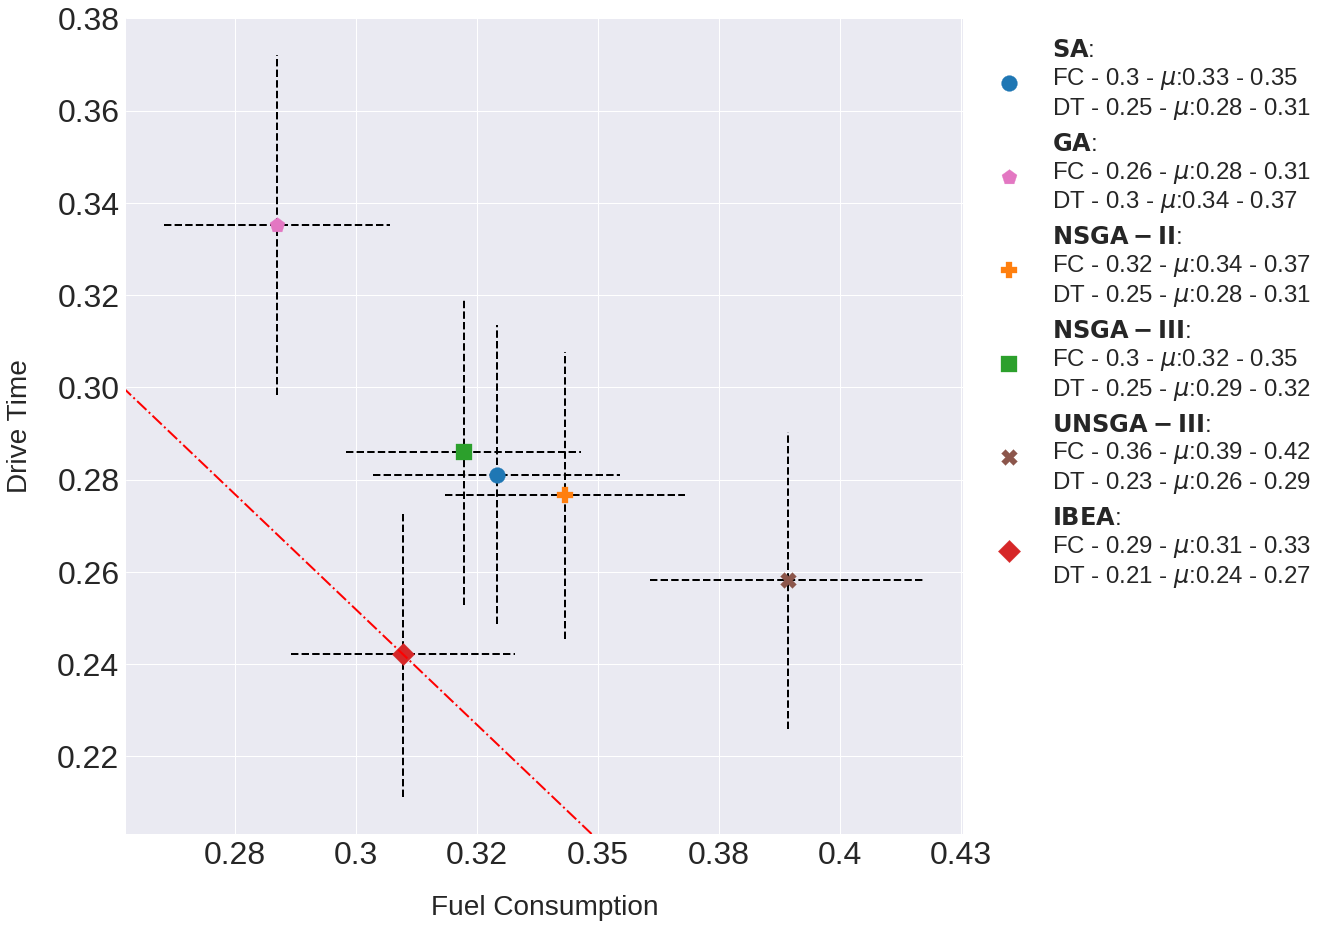

In [12]:
algorithms = [SA_data_evaluation_limited_mean, GA_data_evaluation_limited_mean, NSGA2_data_evaluation_limited_mean, NSGA3_data_evaluation_limited_mean, UNSGA3_data_evaluation_limited_mean, IBEA_data_evaluation_limited_mean]#,IBEA_data_third_objective_mean]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]#,"IBEA-Multiobjective"]
fig, ax = plot_2d_minmax_scaled(algorithms, labels)

x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
point_1,point_2 = get_pareto_line_minmax(algorithms,plt.xlim(),plt.ylim()) 


points = np.array([point_1,point_2])

plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
ax.set_ylim(y0,y1)
ax.set_xlim(x0,x1)
ax.set_xticklabels([np.round(x,2) for x in ax.get_xticks()])

plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format("combined"),bbox_inches='tight')
#plt.tight_layout(pad=2)
plt.show()

In [25]:
from sympy import symbols, solve,Eq
def get_pareto_line(algorithms,xlim,ylim):
    best_sol = list(sorted(algorithms,key=lambda x: x.fuel_consumption_final_mean + x.longest_route_time_final))[0]
    best_obj_sum =  best_sol.fuel_consumption_final+best_sol.longest_route_time_final#best_sol.objective_sum
    best_obj_x =  best_sol.fuel_consumption_final
    best_obj_y =  best_sol.longest_route_time_final
    
    x0,x1 = xlim
    y0,y1 = ylim
    test_x = best_obj_sum - y0
    
    k = (best_obj_y-y0)/(best_obj_x-test_x)
    m = best_obj_y- (best_obj_x*k)
    
    point_2_x = symbols('x')
    expr = (point_2_x*k) + m
    sol = solve(expr)
    point_1 = (0,m)
    point_2 = (sol[0],0) 
    return point_1,point_2

In [10]:
from sympy import symbols, solve,Eq
def get_pareto_line_minmax(algorithms,xlim,ylim):
    best_sol = list(sorted(algorithms,key=lambda x: x.fuel_consumption_final_minmax_mean + x.longest_route_time_final_minmax_mean))[0]
    best_obj_sum =  best_sol.fuel_consumption_final_minmax_mean+best_sol.longest_route_time_final_minmax_mean#best_sol.objective_sum
    best_obj_x =  best_sol.fuel_consumption_final_minmax_mean
    best_obj_y =  best_sol.longest_route_time_final_minmax_mean
    
    x0,x1 = xlim
    y0,y1 = ylim
    test_x = best_obj_sum - y0
    
    k = (best_obj_y-y0)/(best_obj_x-test_x)
    m = best_obj_y- (best_obj_x*k)
    
    point_2_x = symbols('x')
    expr = (point_2_x*k) + m
    sol = solve(expr)
    point_1 = (0,m)
    point_2 = (sol[0],0) 
    return point_1,point_2

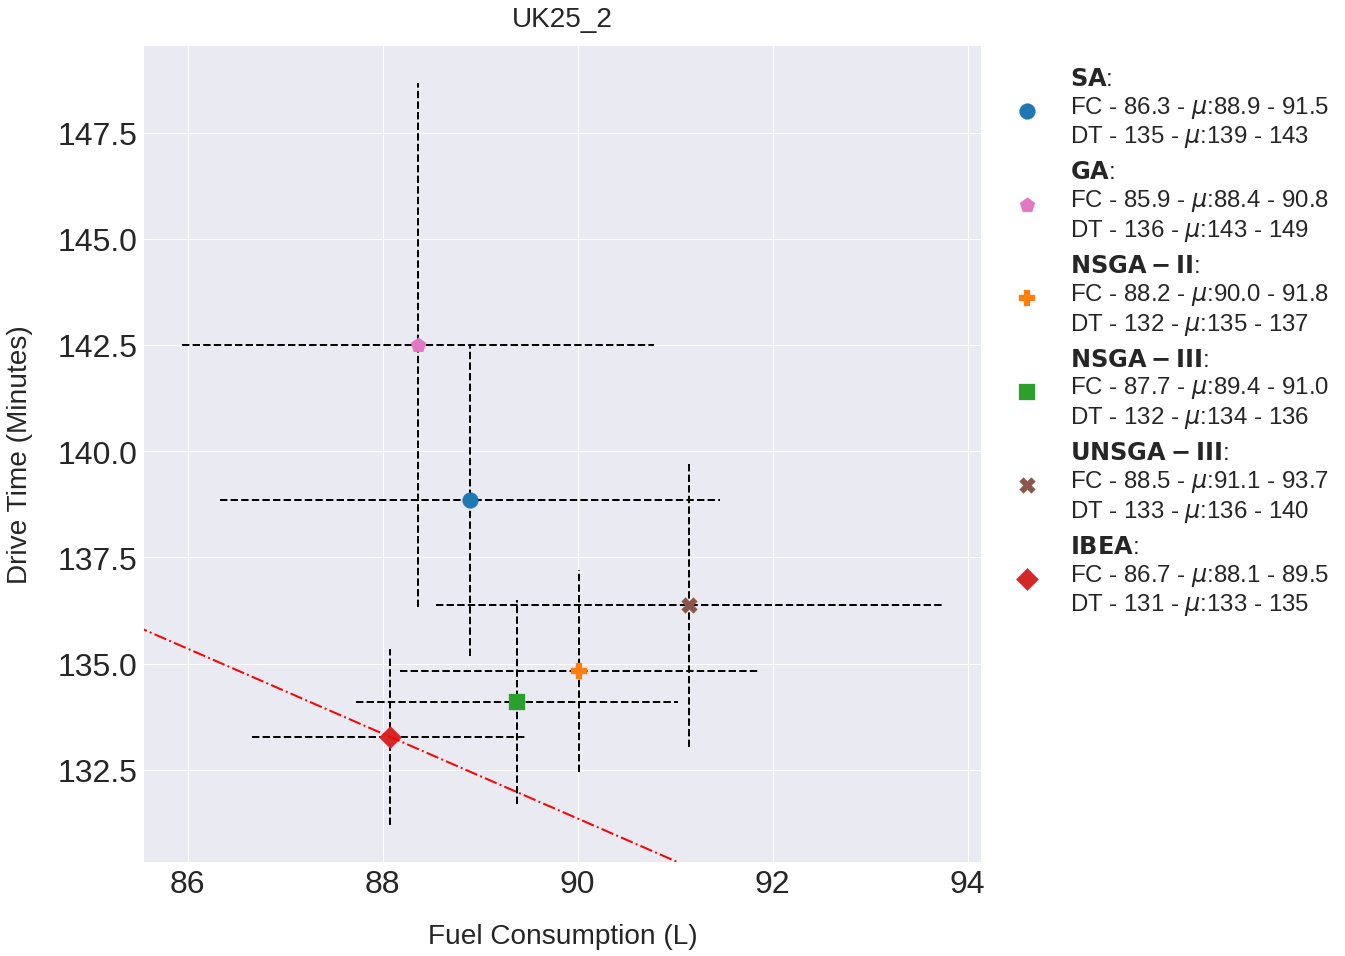

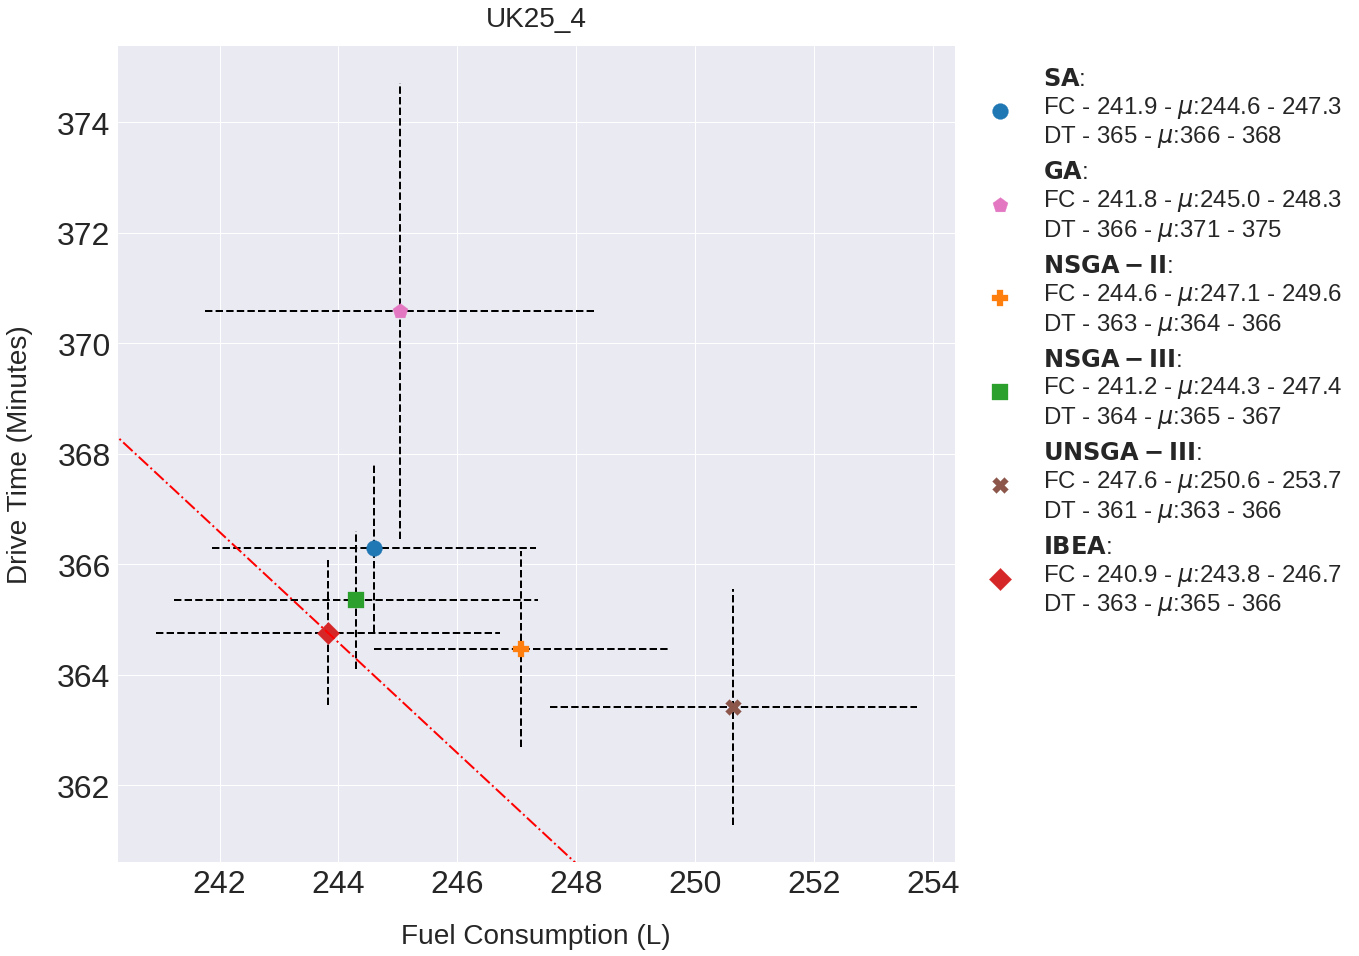

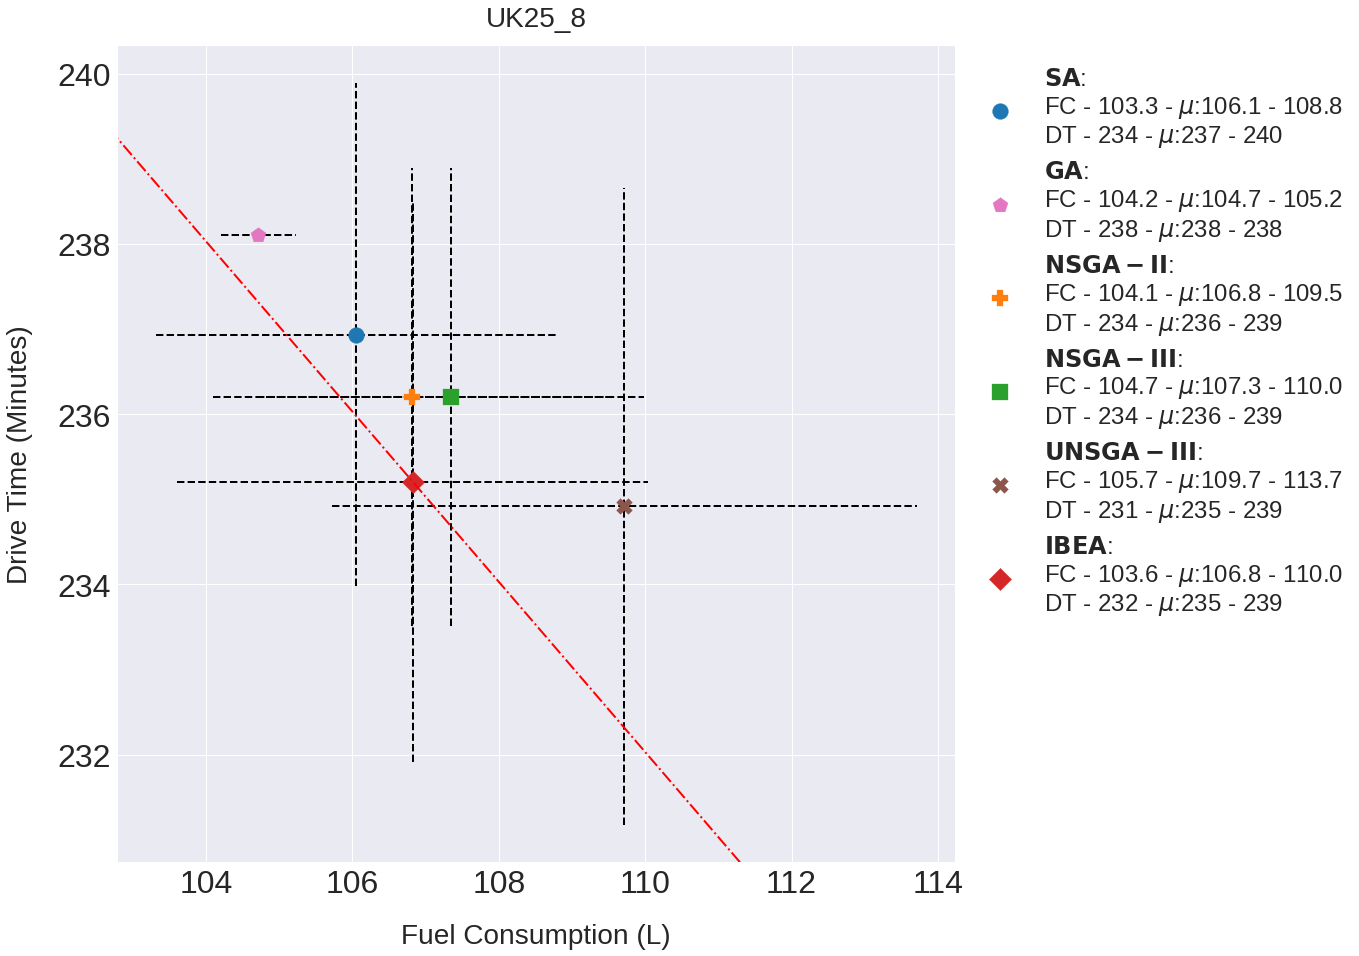

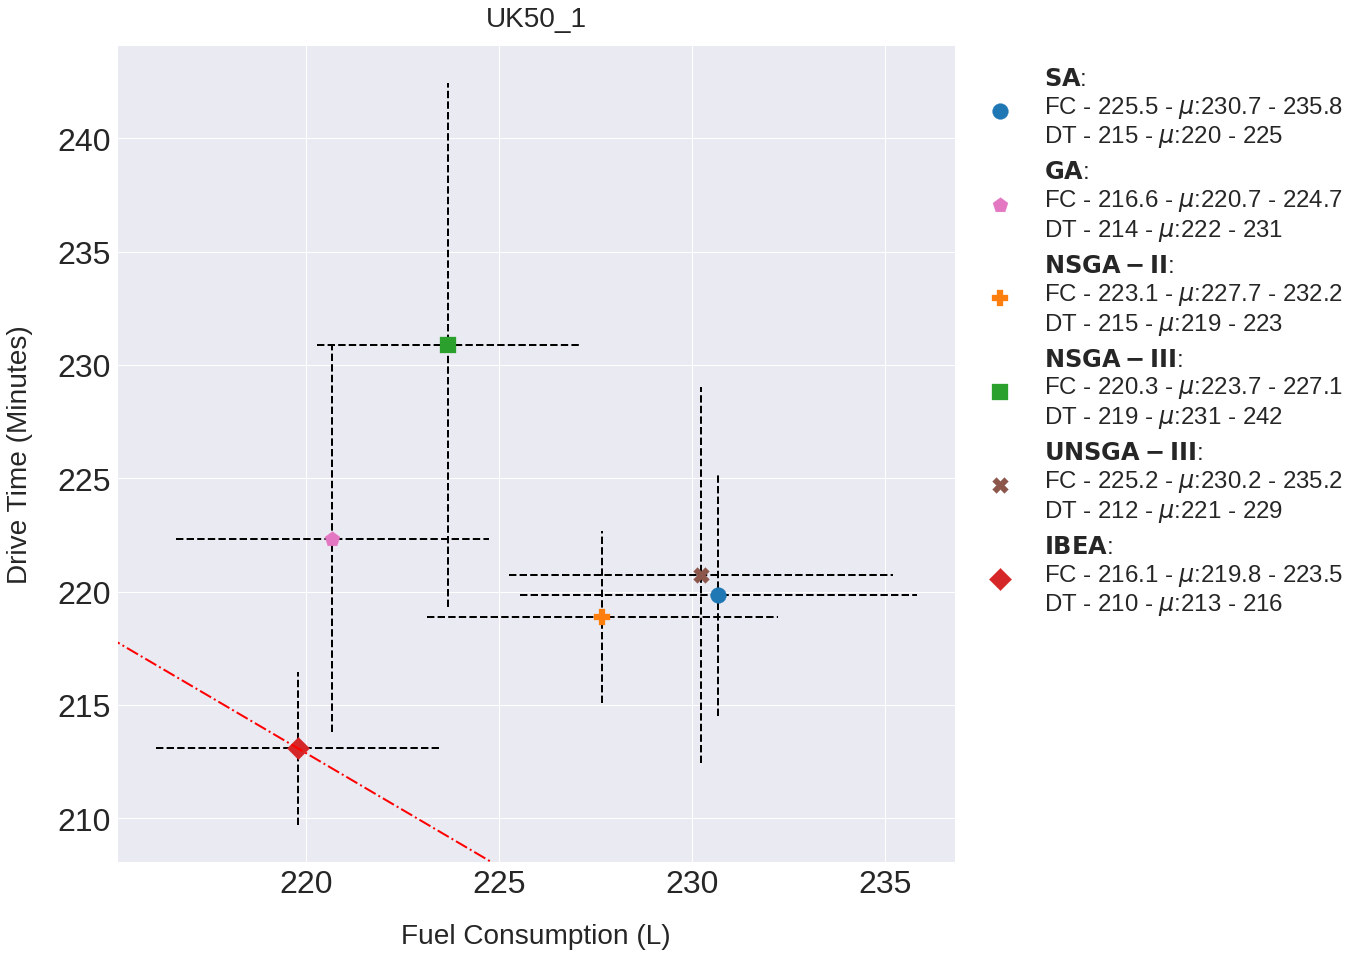

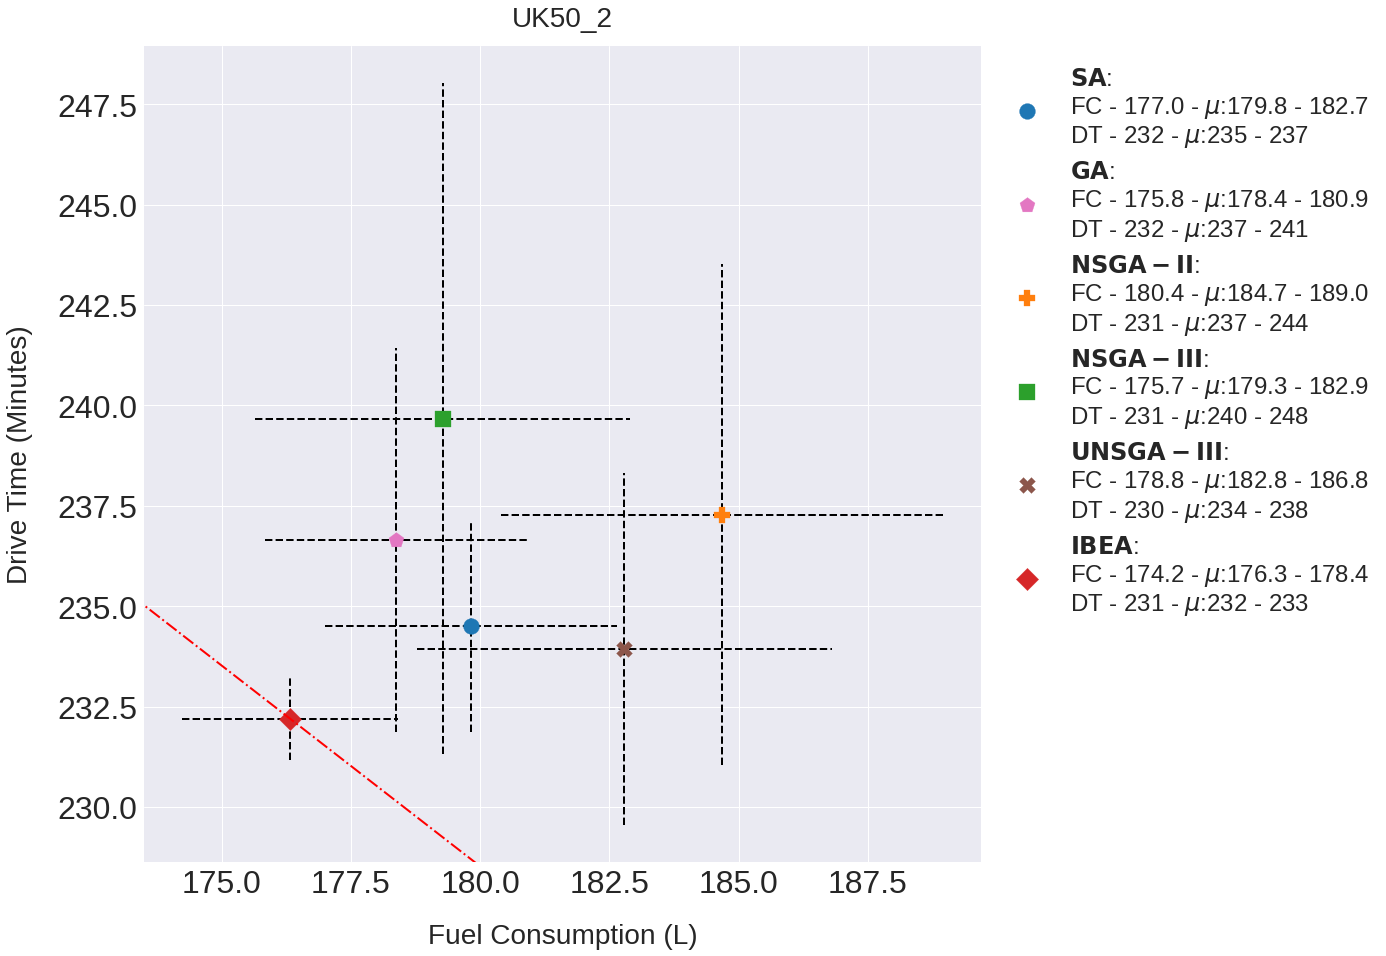

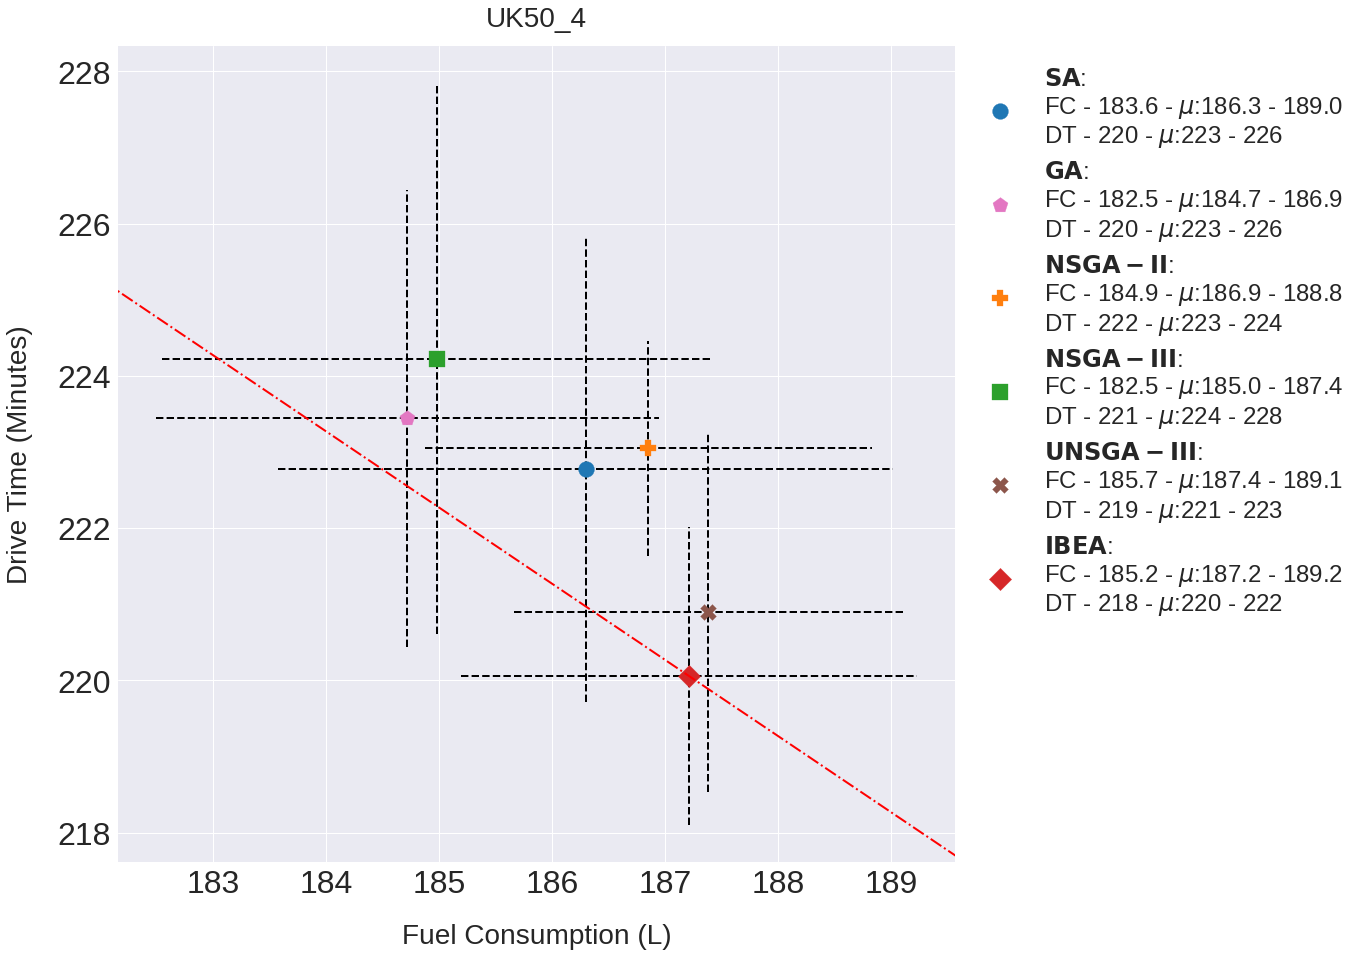

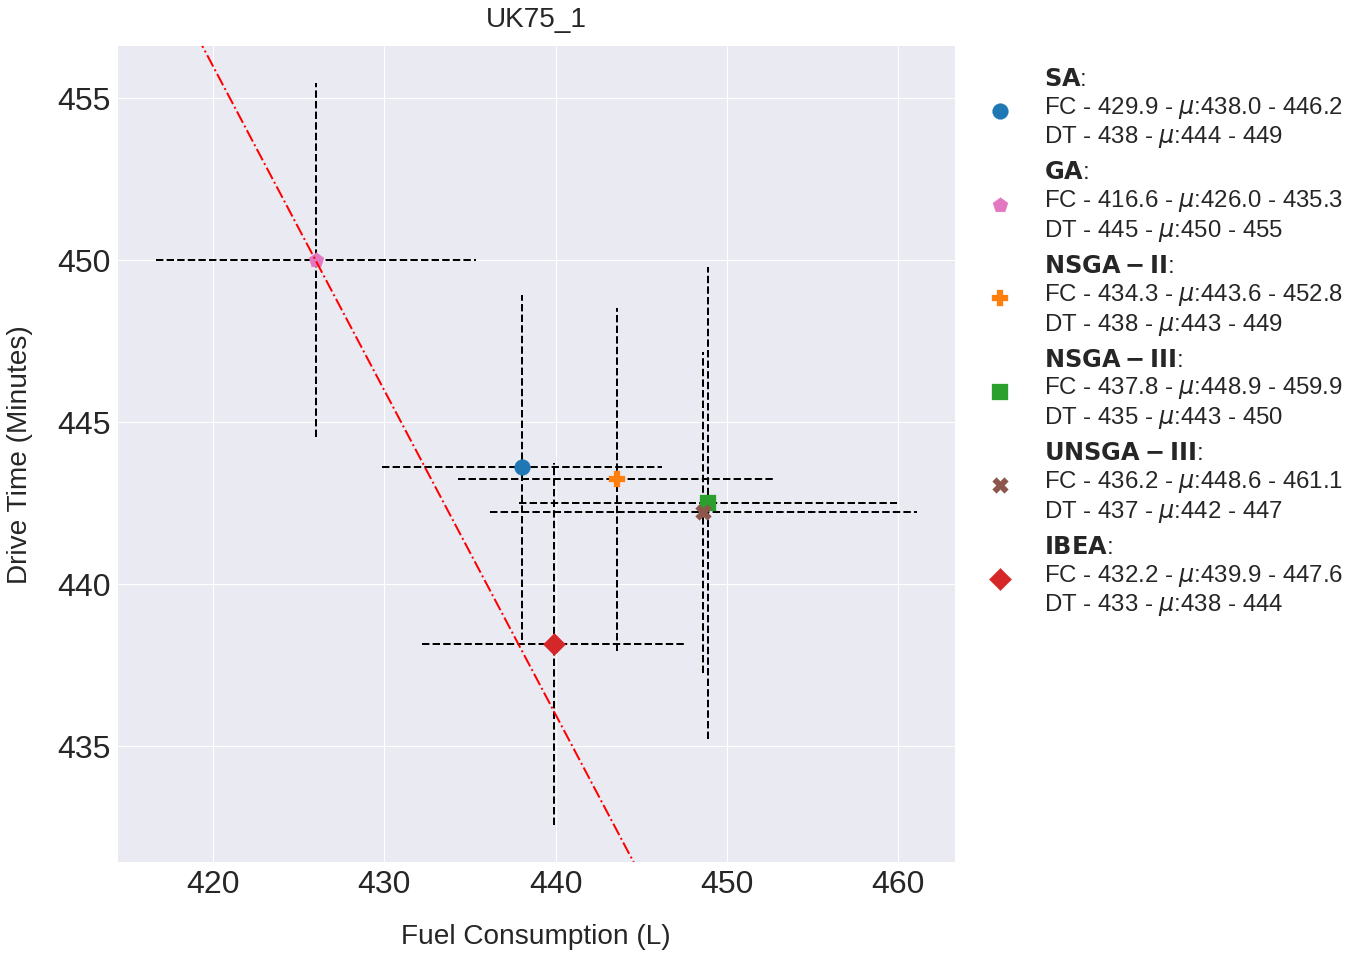

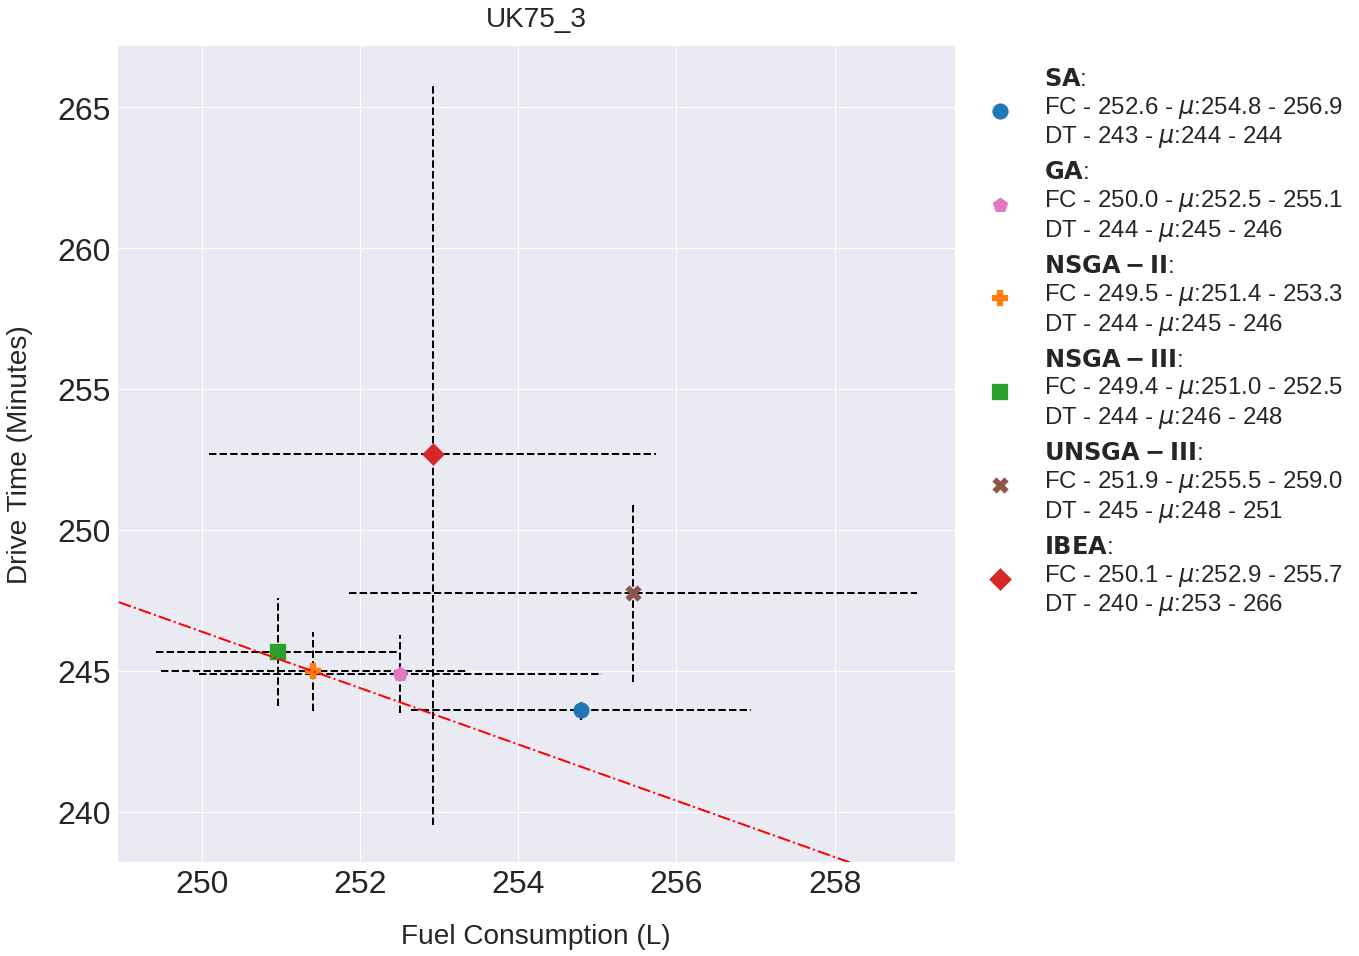

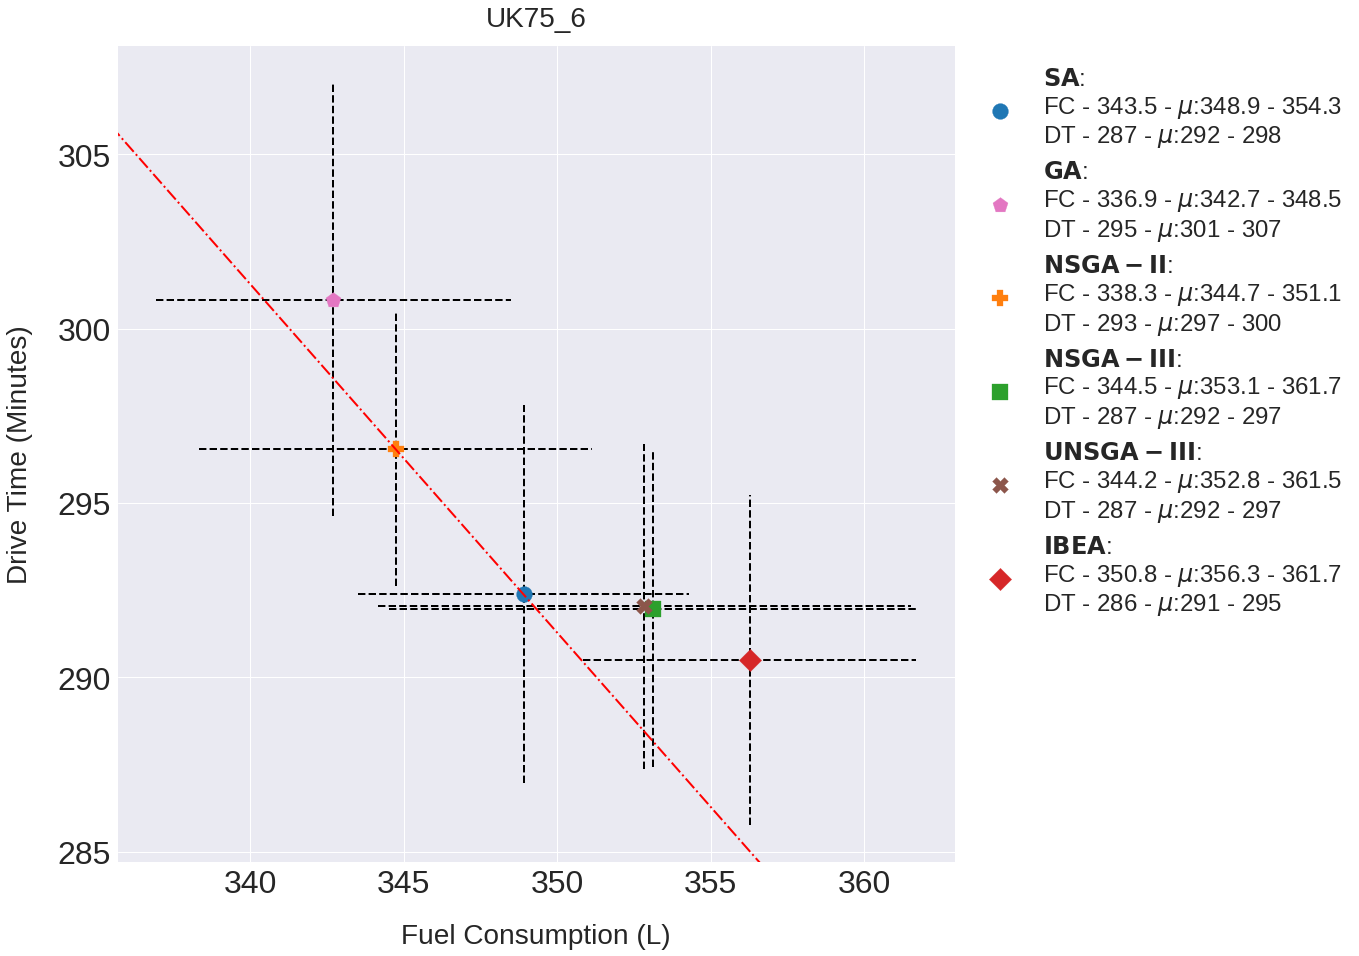

In [27]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA","IBEA-Multiobjective"]



for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    #IBEA_data_third_objective_dataset = IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == dataset).dropna(how="all").mean()
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]#,IBEA_data_third_objective_dataset]
    
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)

    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    plt.title(dataset)
    plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()

array([ 3., -1.])

(0.0, 1.0)

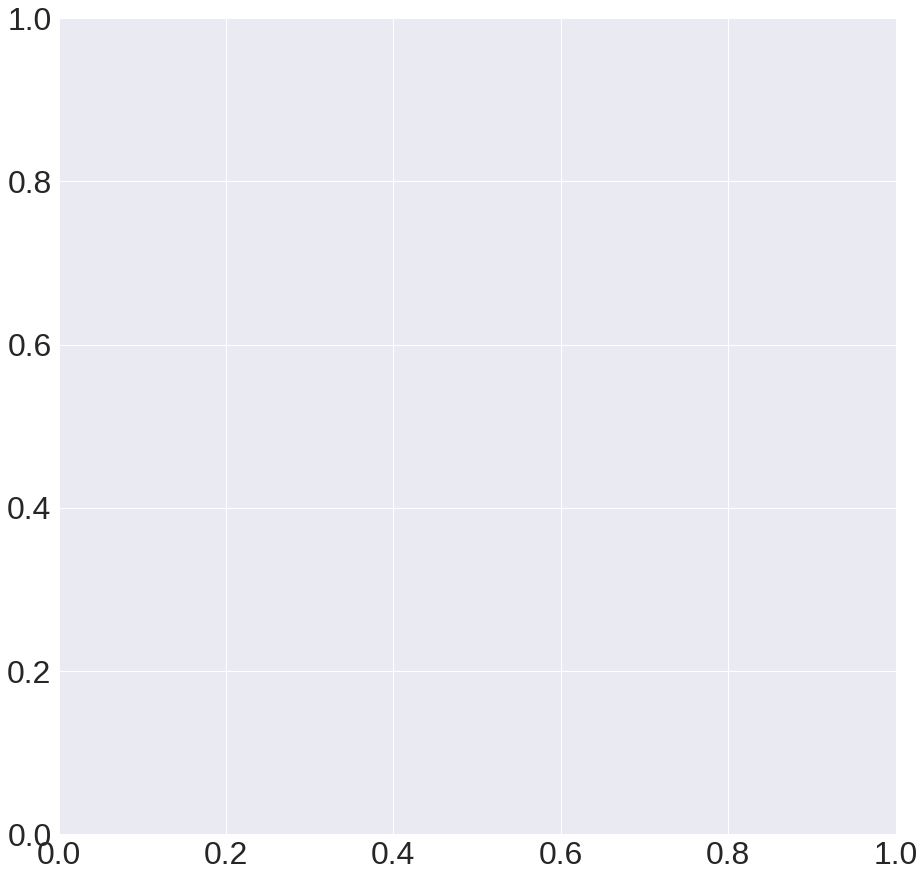

## uk25_ibea = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset =="UK50_1").dropna(how ="all")

#uk25_ibea["distance_to_origin_final"] = [x[-1] for x in uk25_ibea.distance_to_origin]
print(uk25_ibea.sort_values(by = "distance_to_origin").head(1).paths.iloc[0])

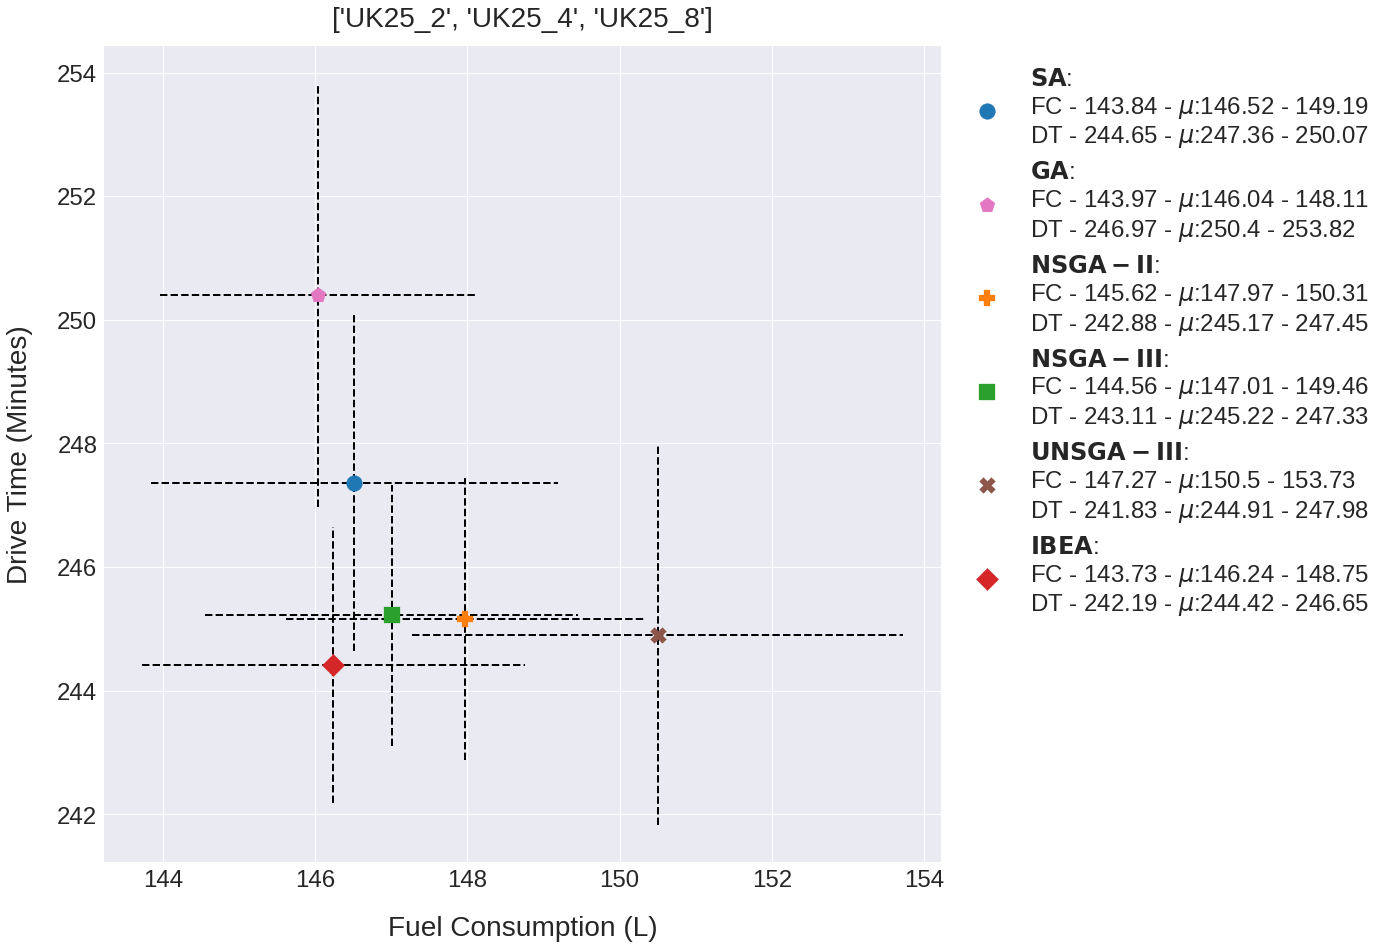

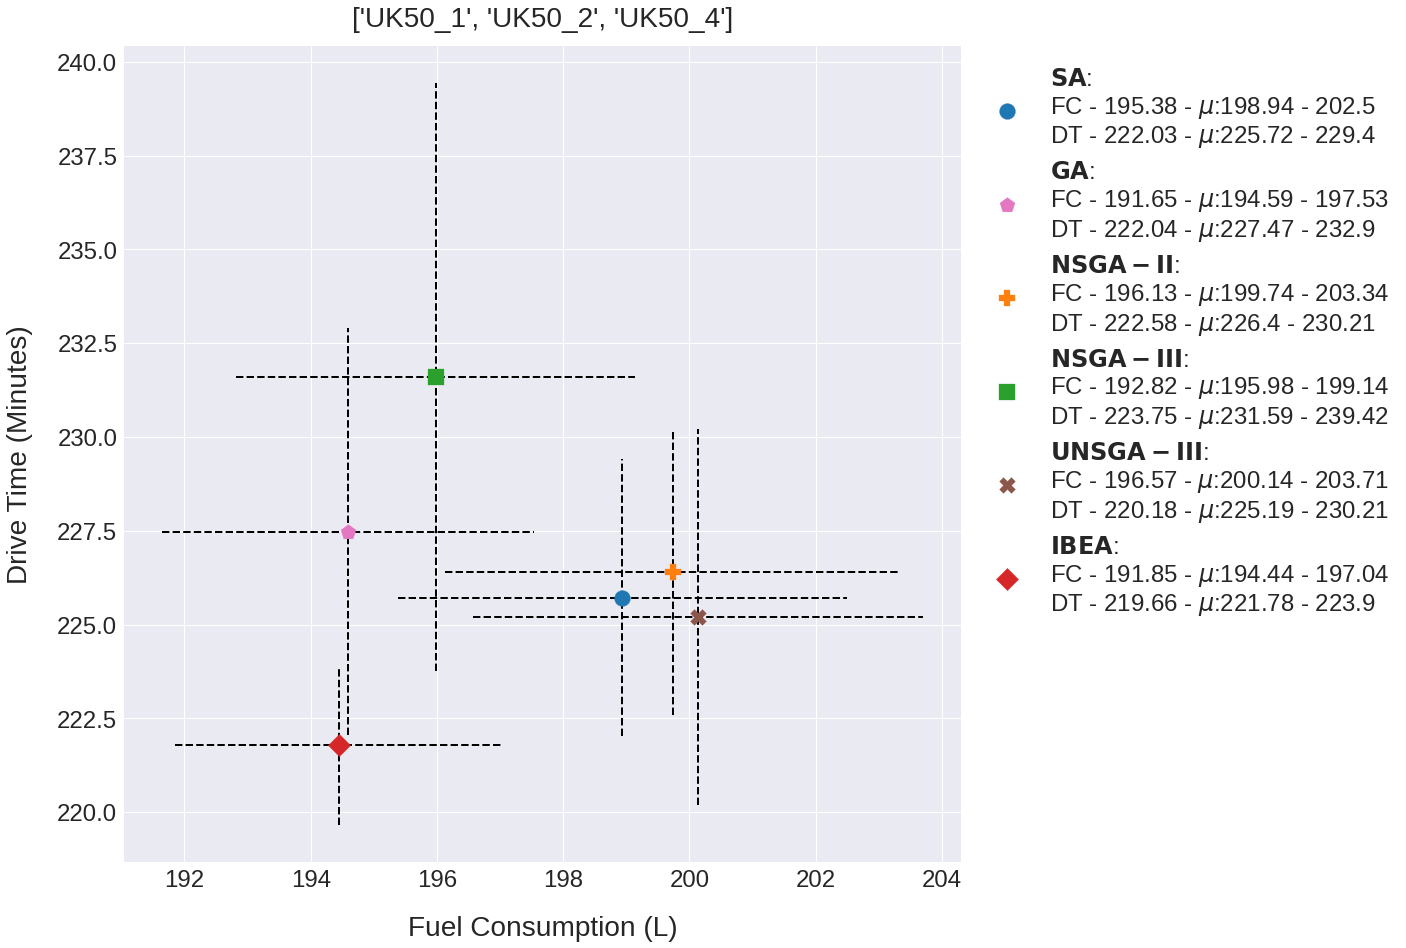

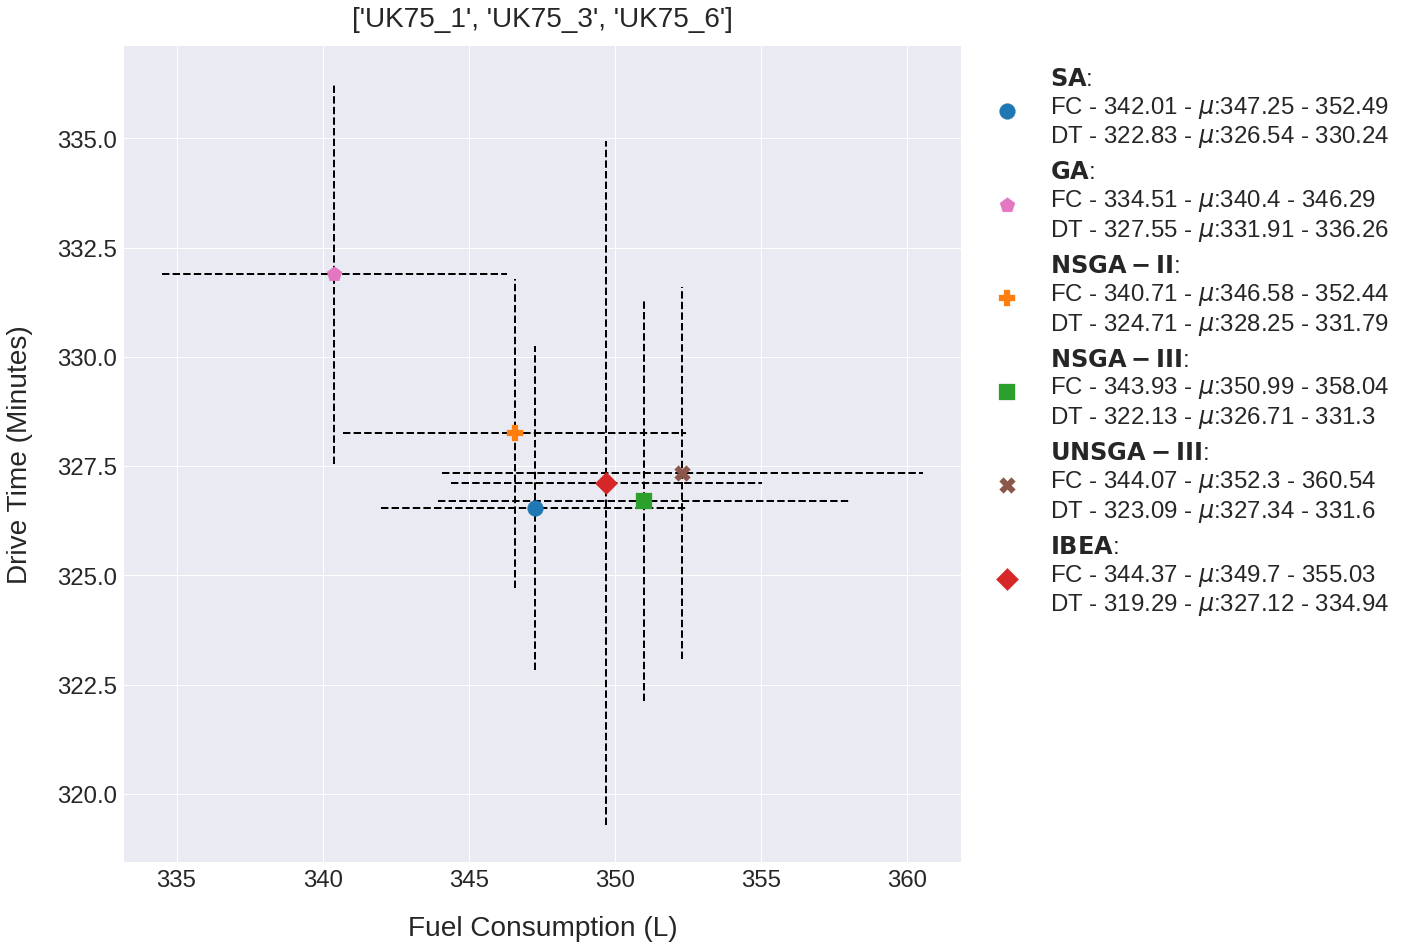

In [50]:
dataset_names =  [["UK25_2", "UK25_4", "UK25_8"],[ "UK50_1", "UK50_2", "UK50_4"],[ "UK75_1","UK75_3","UK75_6"]]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    

    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    #plt.savefig("2d_plot_fuel_drivetime_evaluation_limited_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()
    


# Plot evaluation limited divided into the three different dataset sizes

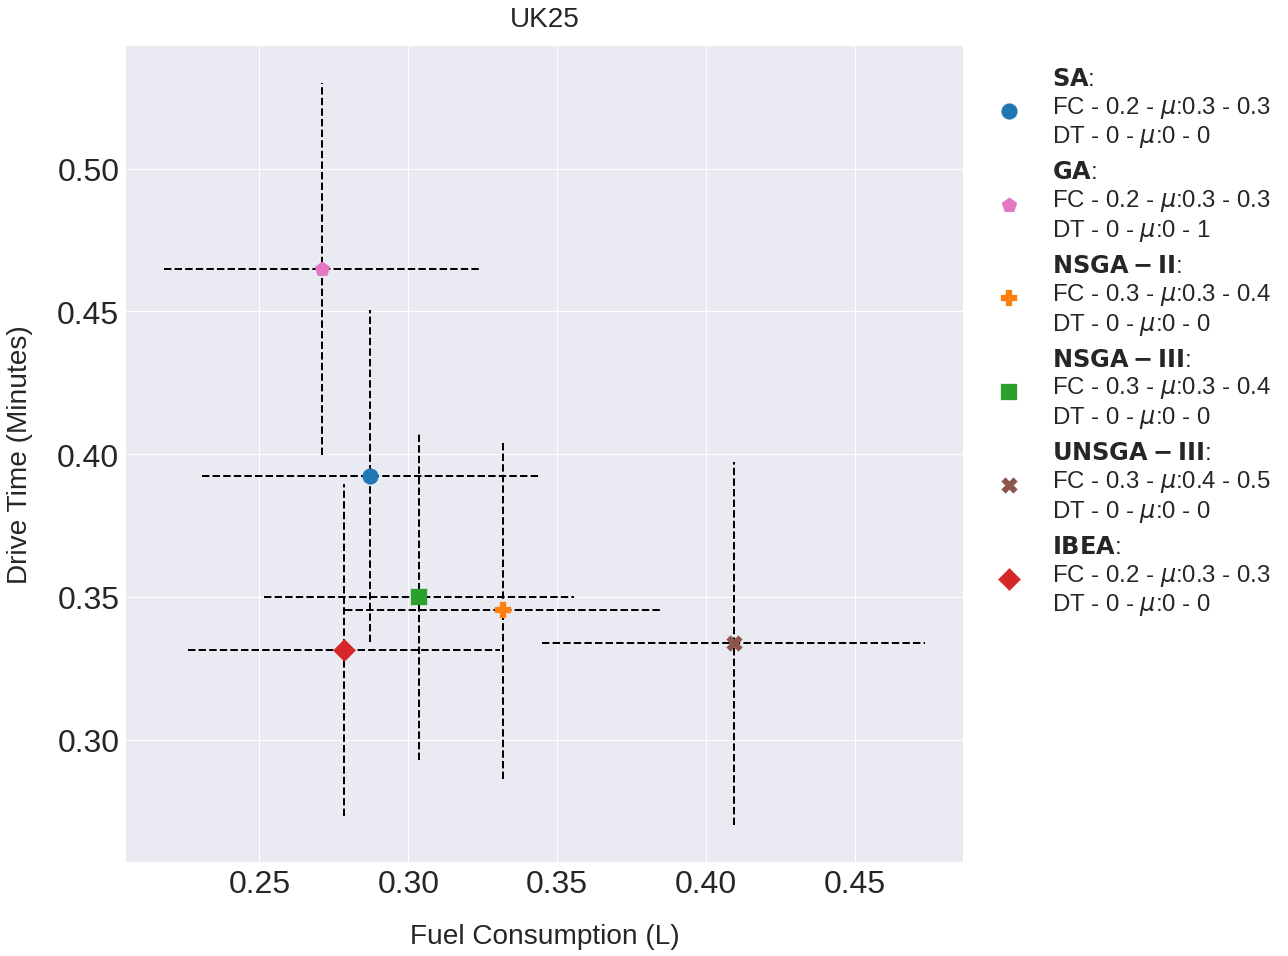

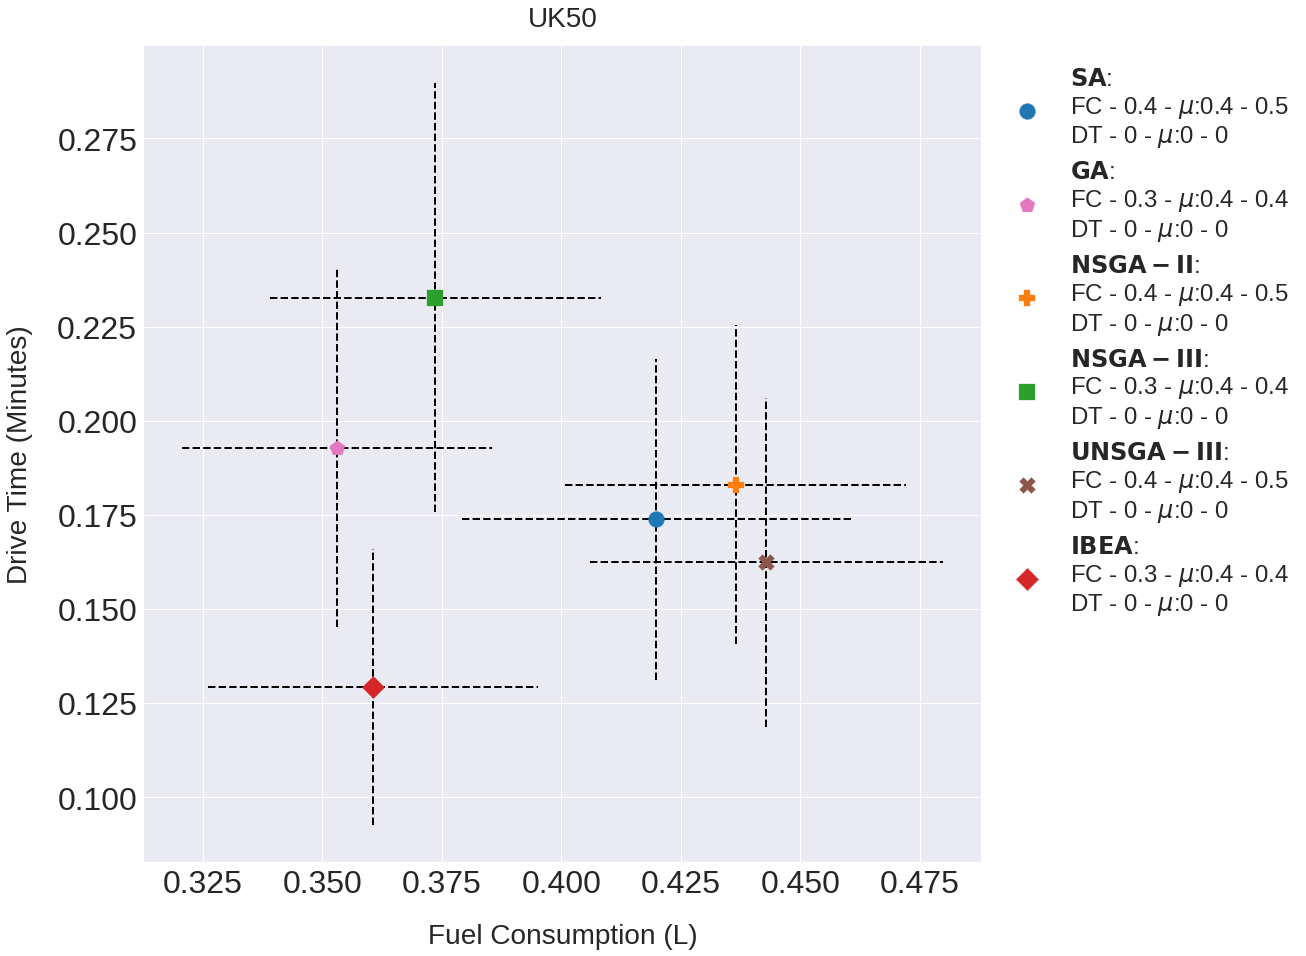

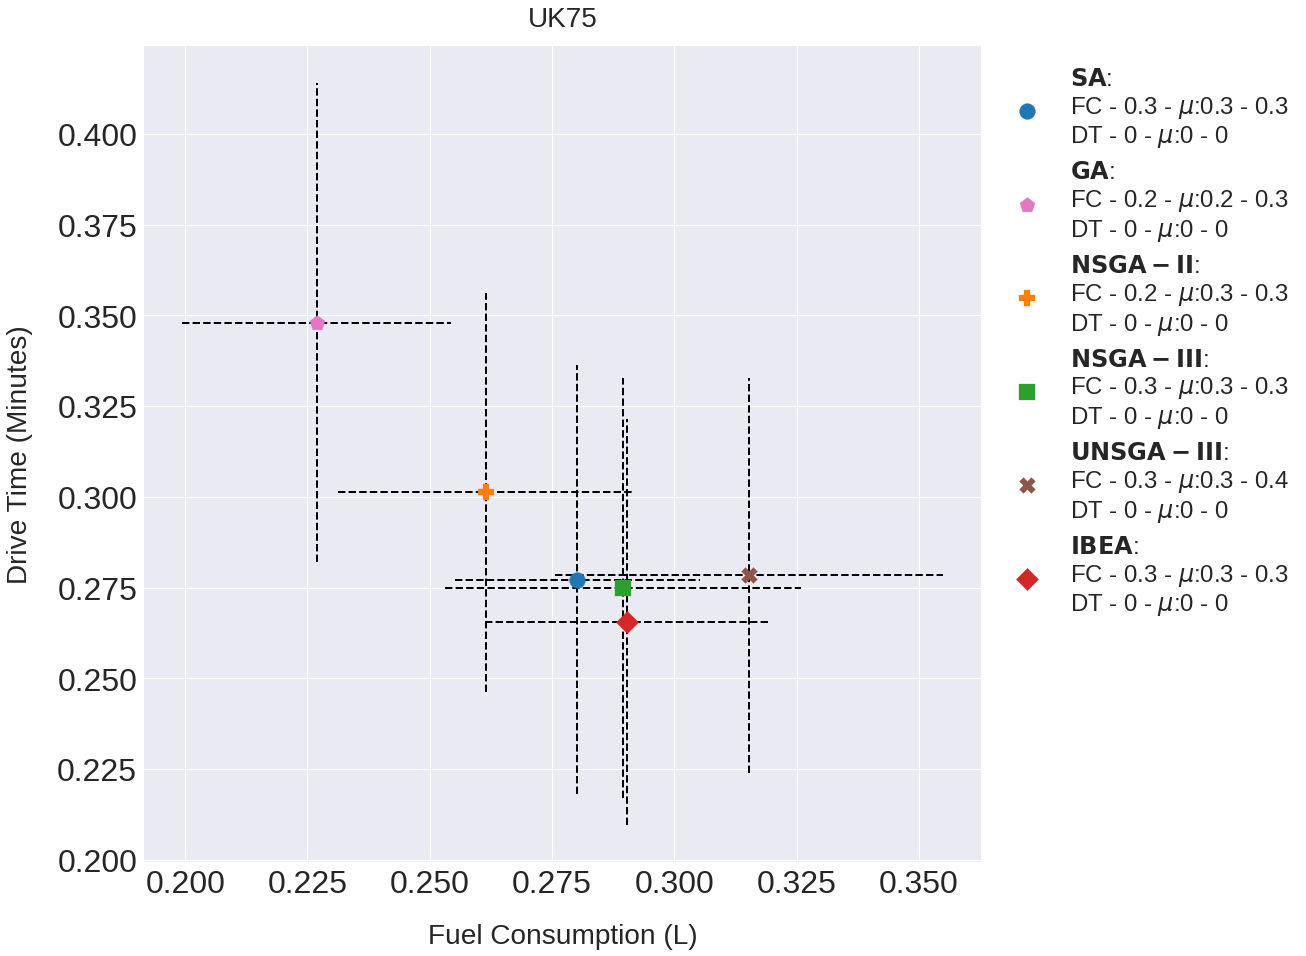

In [105]:

dataset_names =  [["UK25_2", "UK25_4", "UK25_8"],[ "UK50_1", "UK50_2", "UK50_4"],[ "UK75_1","UK75_3","UK75_6"]]
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset.isin(dataset)).dropna(how="all")#.mean()
    
    
    
    
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    add_minmax_fuel_drivetime_columns(algorithms,dataset)
    
    SA_data_dataset = SA_data_dataset.mean()
    GA_data_dataset = GA_data_dataset.mean()
    NSGA2_data_dataset = NSGA2_data_dataset.mean()
    NSGA3_data_dataset = NSGA3_data_dataset.mean()
    UNSGA3_data_dataset = UNSGA3_data_dataset.mean()
    IBEA_data_dataset = IBEA_data_dataset.mean()
    
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset[0][:4])
    #plt.savefig("2d_plot_fuel_drivetime_time_limited_{}.pdf".format(dataset[0][:4]),bbox_inches='tight')
    plt.show()

# Compare Normal vs Pickup and Drop solution (evaluation limited)

In [30]:
import time 
start_time = time.monotonic()
print("SA")

SA_data_evaluation_limited_copy = deepcopy(SA_data_evaluation_limited)
NSGA3_data_evaluation_limited_copy = deepcopy(NSGA3_data_evaluation_limited)
IBEA_data_evaluation_limited_copy = deepcopy(IBEA_data_evaluation_limited)

SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("NSGA3")
NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/")

print("IBEA")
IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/")

add_minmax_fuel_drivetime_columns([SA_data_evaluation_limited_copy,SA_pickup_and_drop,
                                   NSGA3_data_evaluation_limited_copy,NSGA3_pickup_and_drop,
                                   IBEA_data_evaluation_limited_copy,IBEA_pickup_and_drop])

SA_data_evaluation_limited_copy_mean = SA_data_evaluation_limited_copy.mean()
NSGA3_data_evaluation_limited_copy_mean = NSGA3_data_evaluation_limited_copy.mean()
IBEA_data_evaluation_limited_copy_mean = IBEA_data_evaluation_limited_copy.mean()
SA_pickup_and_drop_mean = SA_pickup_and_drop.mean()
NSGA3_pickup_and_drop_mean = NSGA3_pickup_and_drop.mean()
IBEA_pickup_and_drop_mean = IBEA_pickup_and_drop.mean()
print("Time: ", time.monotonic() - start_time)

SA
NSGA3
IBEA
Time:  2.715105462999418


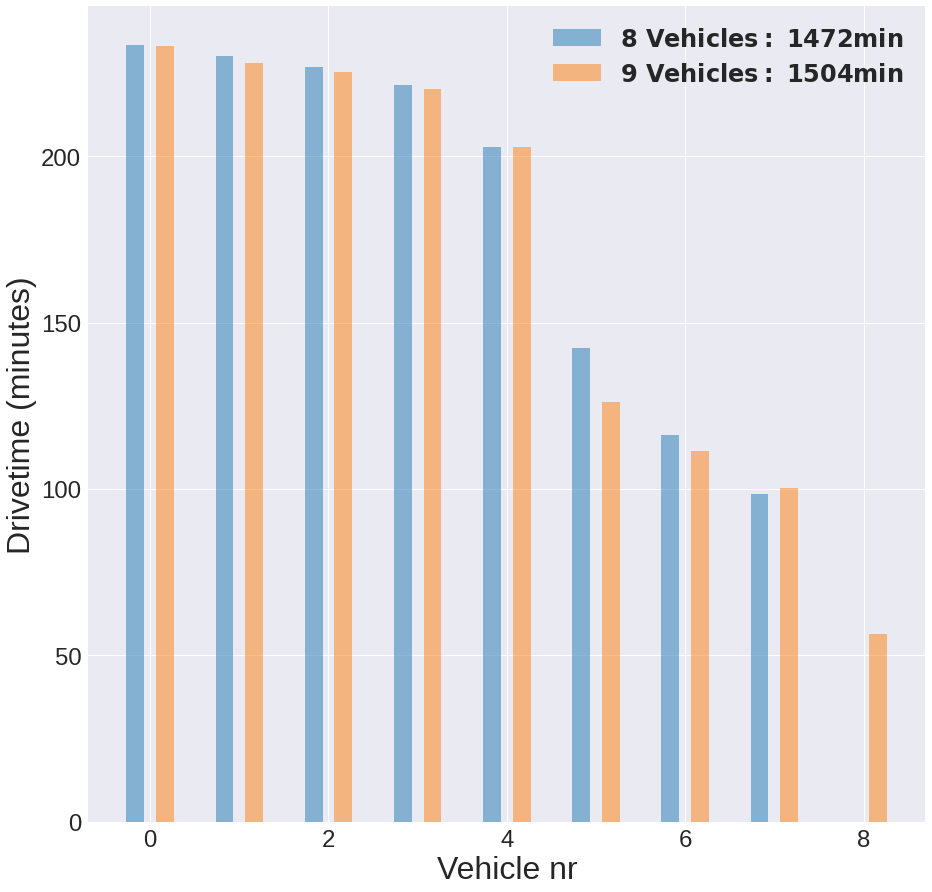

In [18]:
plot_vehicle_drivetimes2(IBEA_pickup_and_drop,"UK50_2")

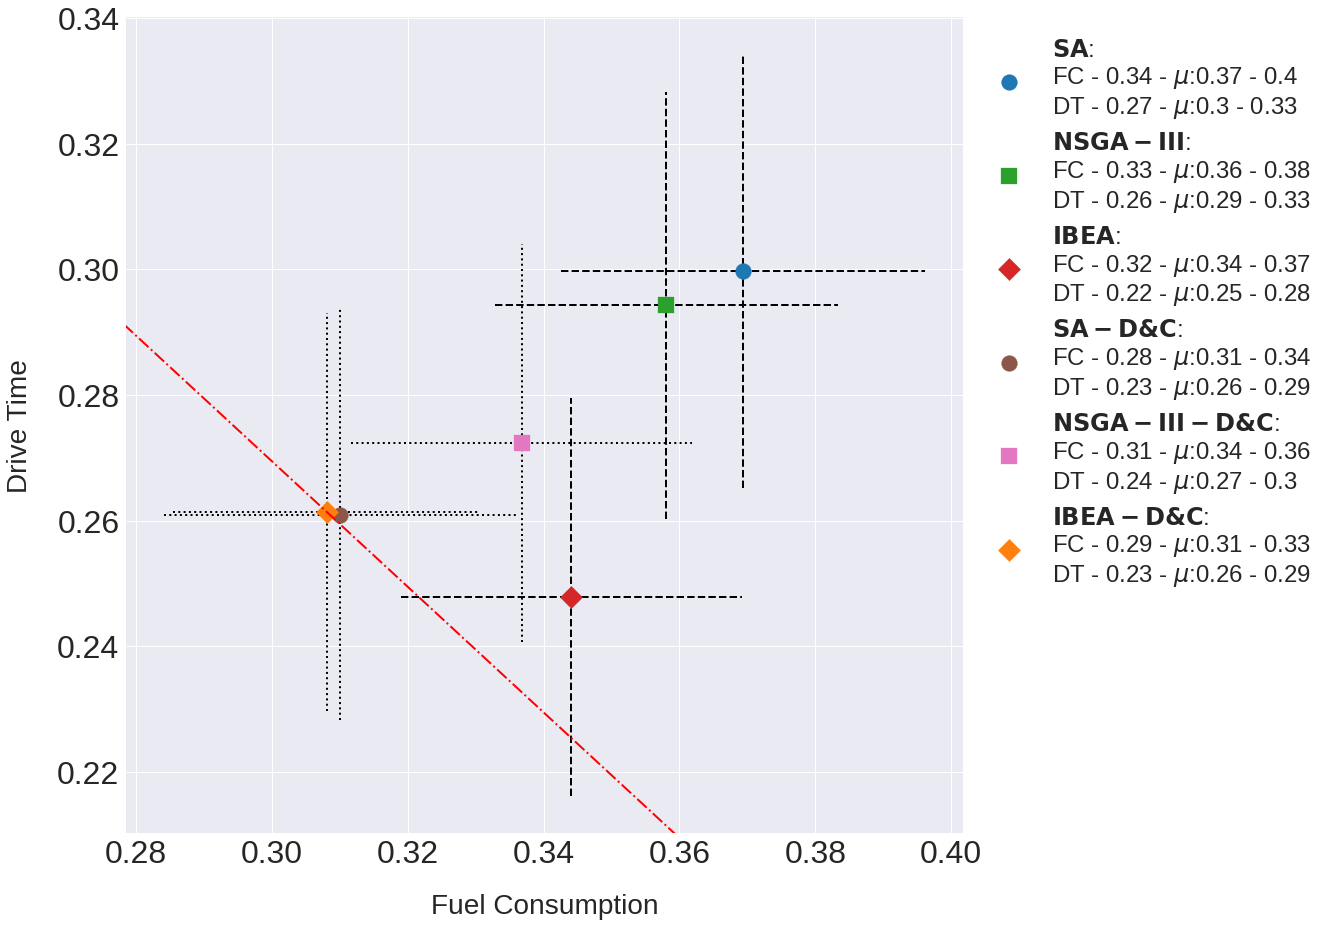

In [63]:
algorithms = [SA_data_evaluation_limited_copy_mean, NSGA3_data_evaluation_limited_copy_mean, IBEA_data_evaluation_limited_copy_mean
              , SA_pickup_and_drop_mean, NSGA3_pickup_and_drop_mean, IBEA_pickup_and_drop_mean]
labels =  ["SA", "NSGA-III","IBEA" ,"SA-D&C", "NSGA-III-D&C","IBEA-D&C" ]




fig, ax = plot_2d_minmax_scaled(algorithms, labels)


x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
point_1,point_2 = get_pareto_line_minmax(algorithms,plt.xlim(),plt.ylim()) 


points = np.array([point_1,point_2])

plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
ax.set_ylim(y0,y1)
ax.set_xlim(x0,x1)
#ax.set_xticklabels([np.round(x,2) for x in ax.get_xticks()])


plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
plt.savefig("2d_plot_fuel_drivetime_pickup_and_drop_{}.pdf".format("combined"),bbox_inches='tight')
#plt.tight_layout(pad=2)
plt.show()

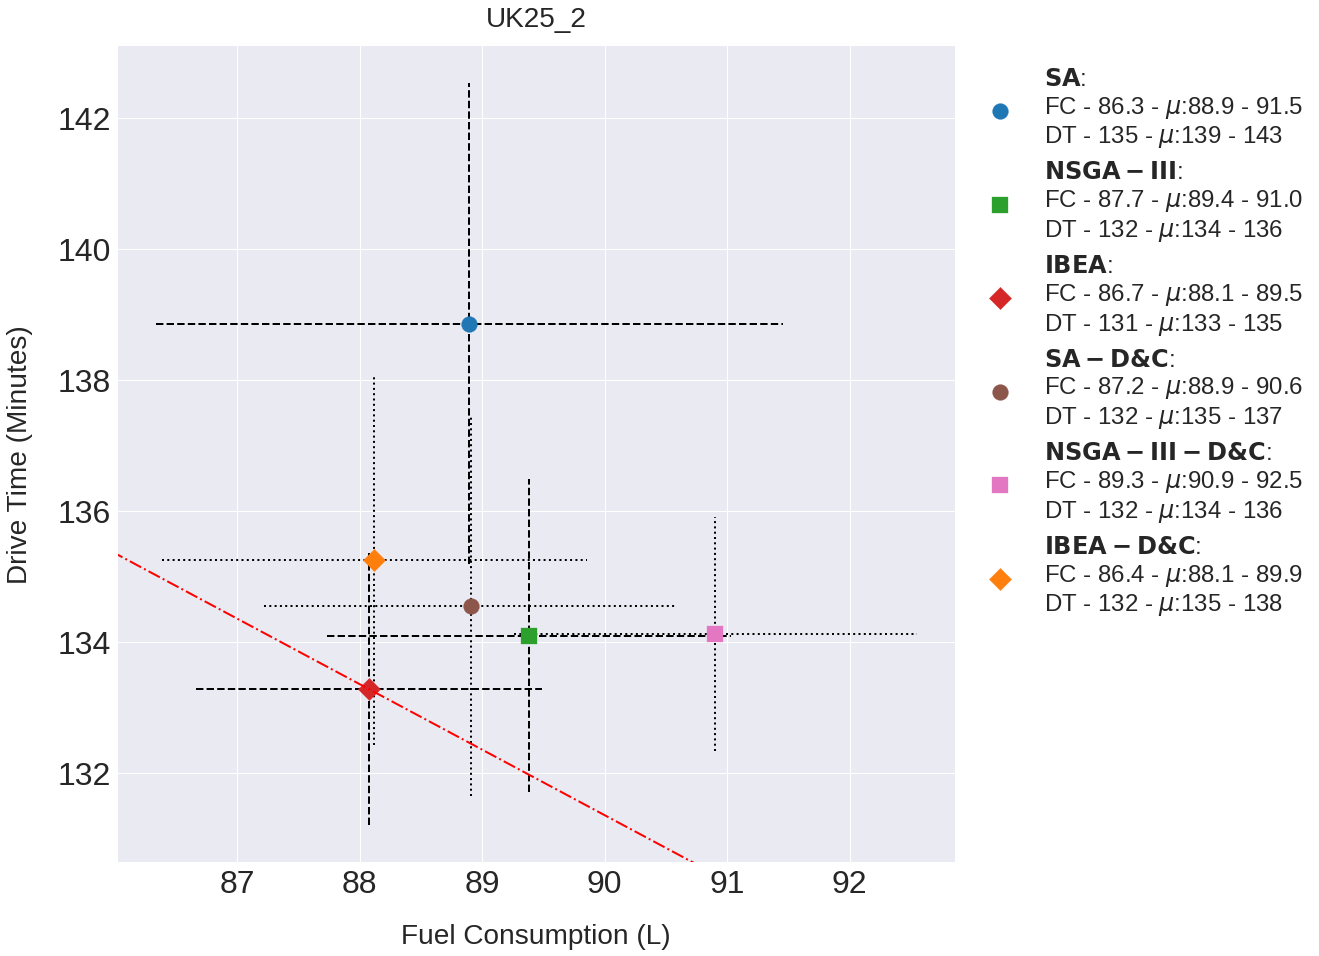

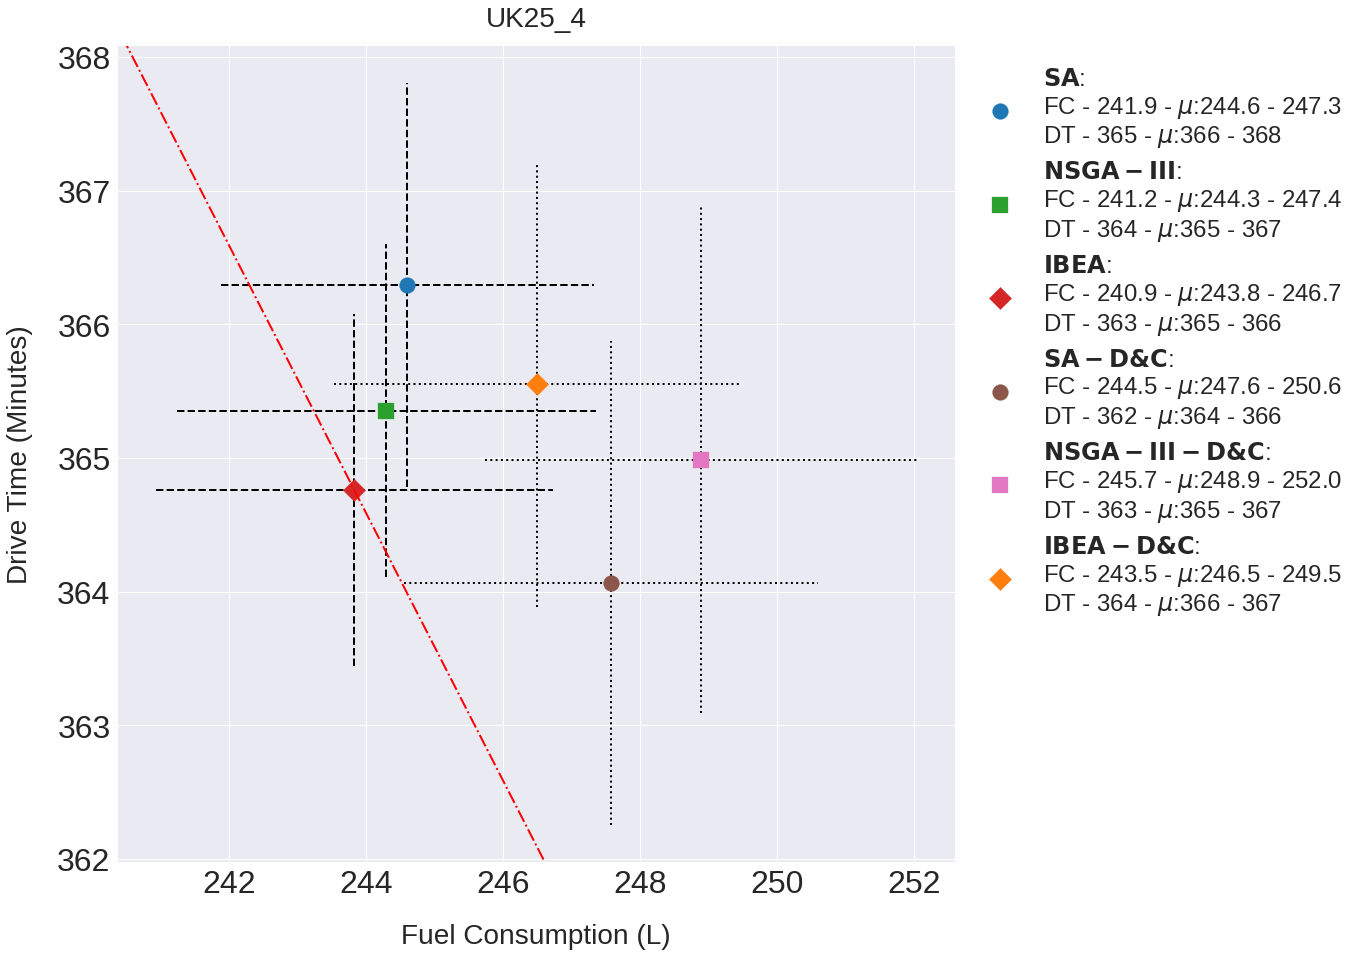

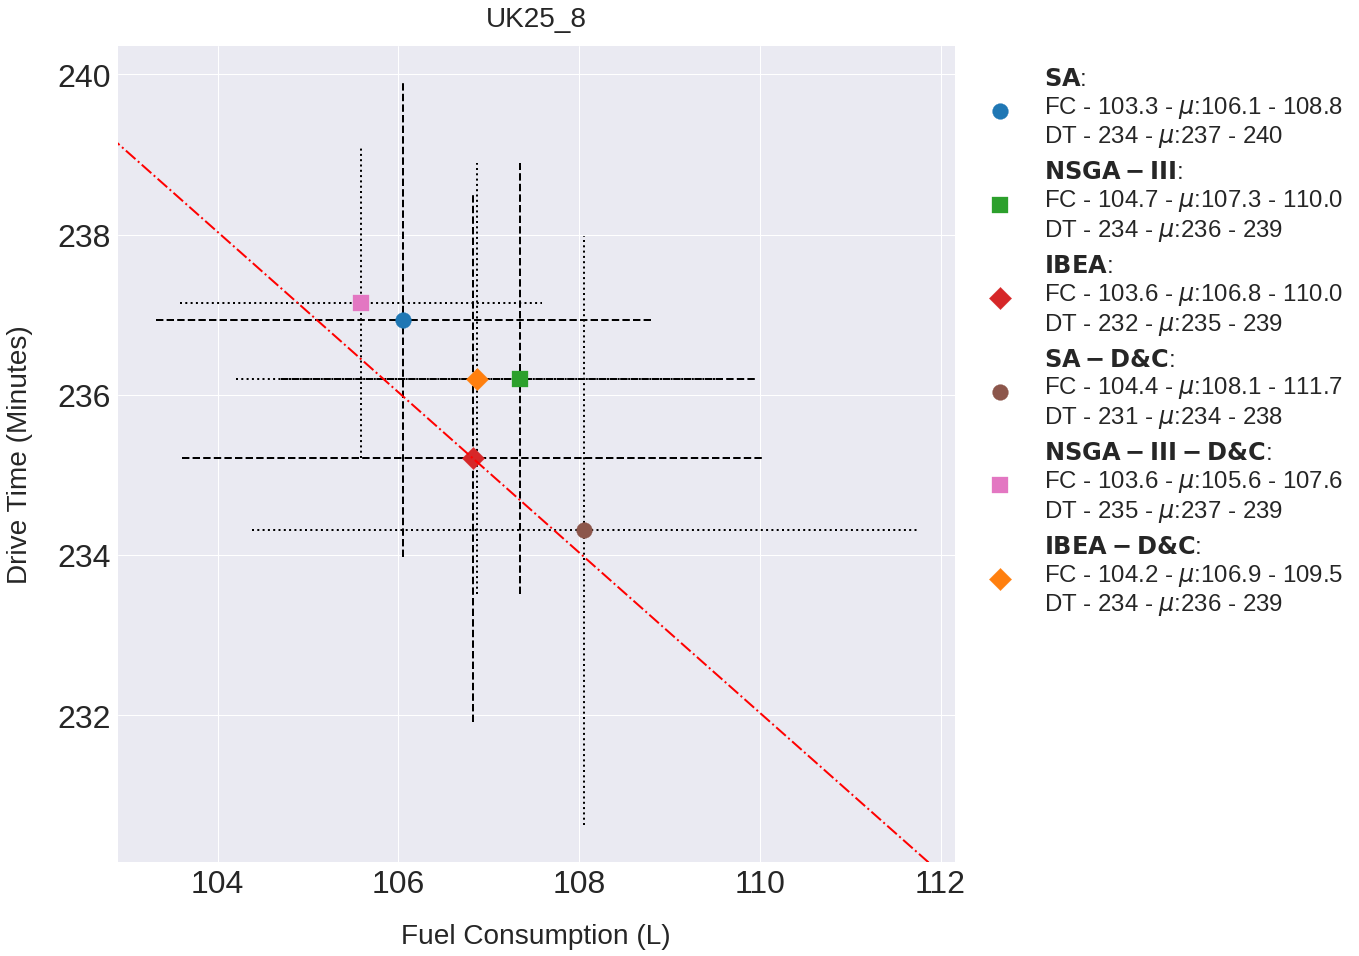

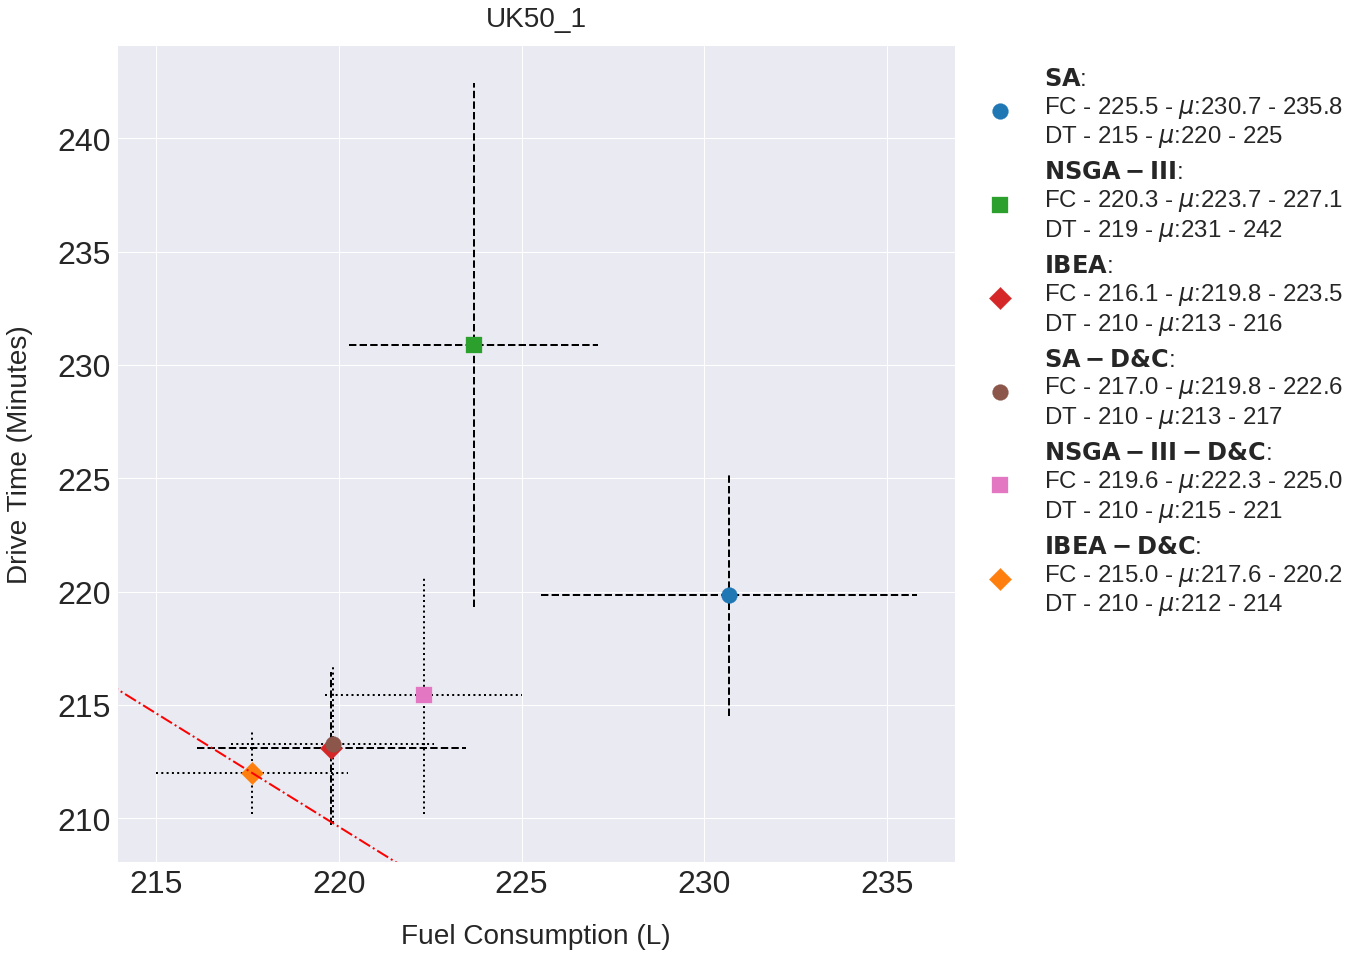

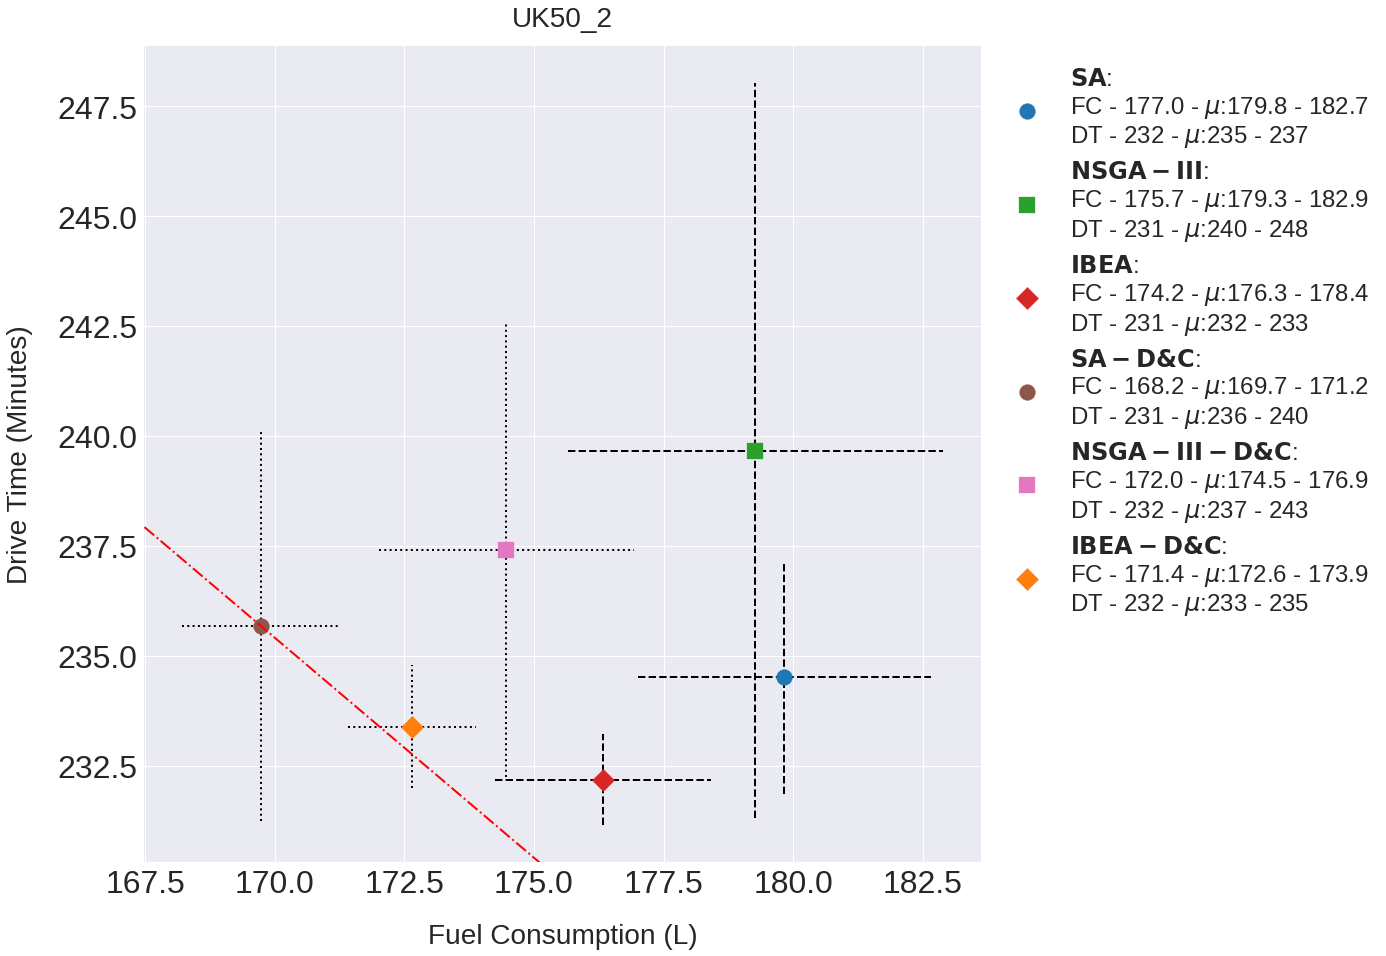

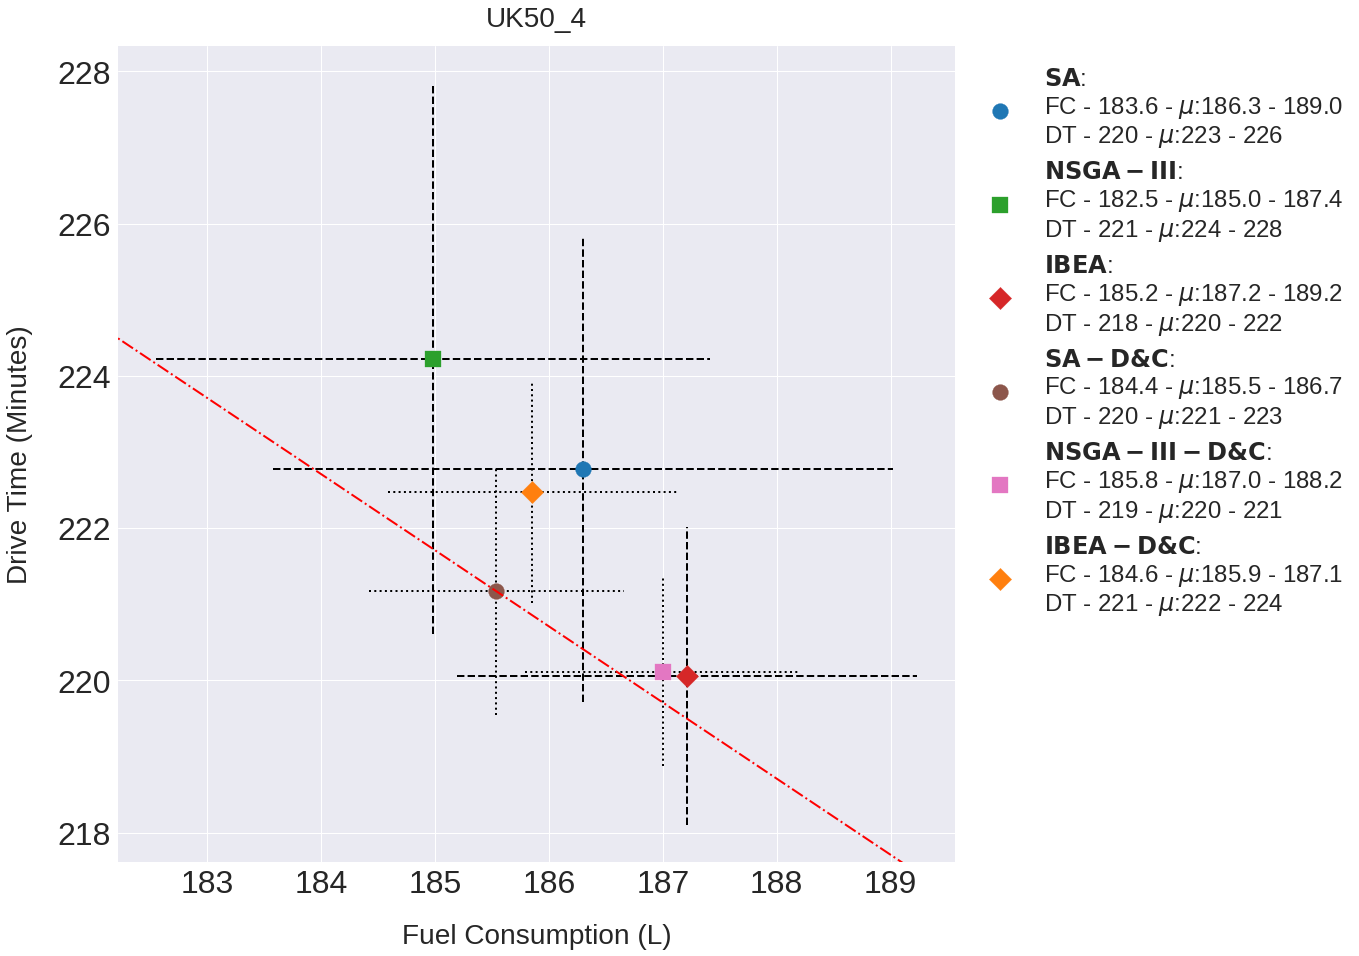

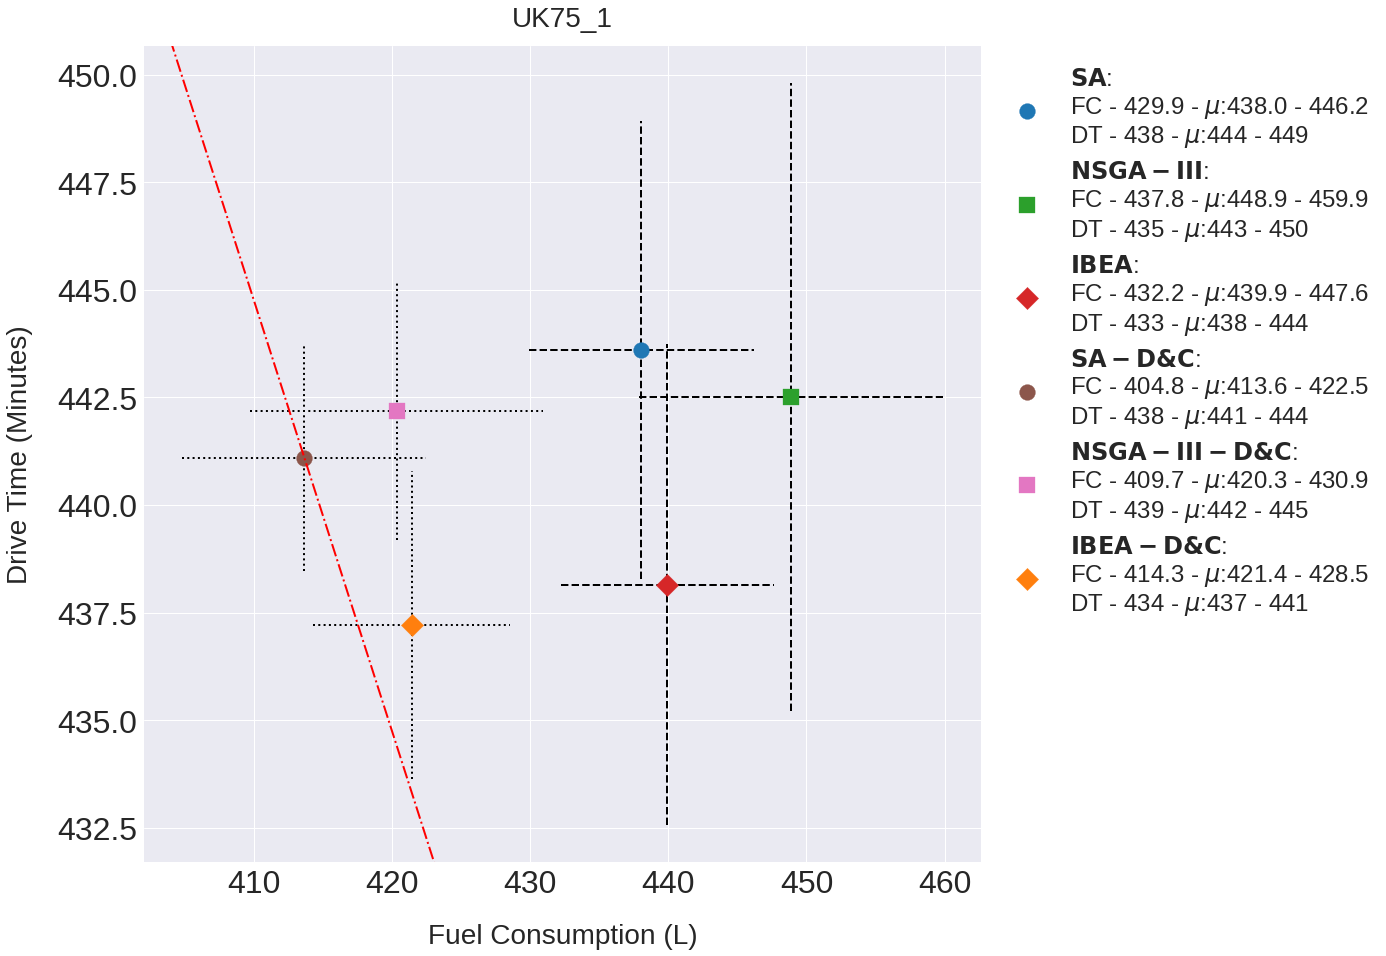

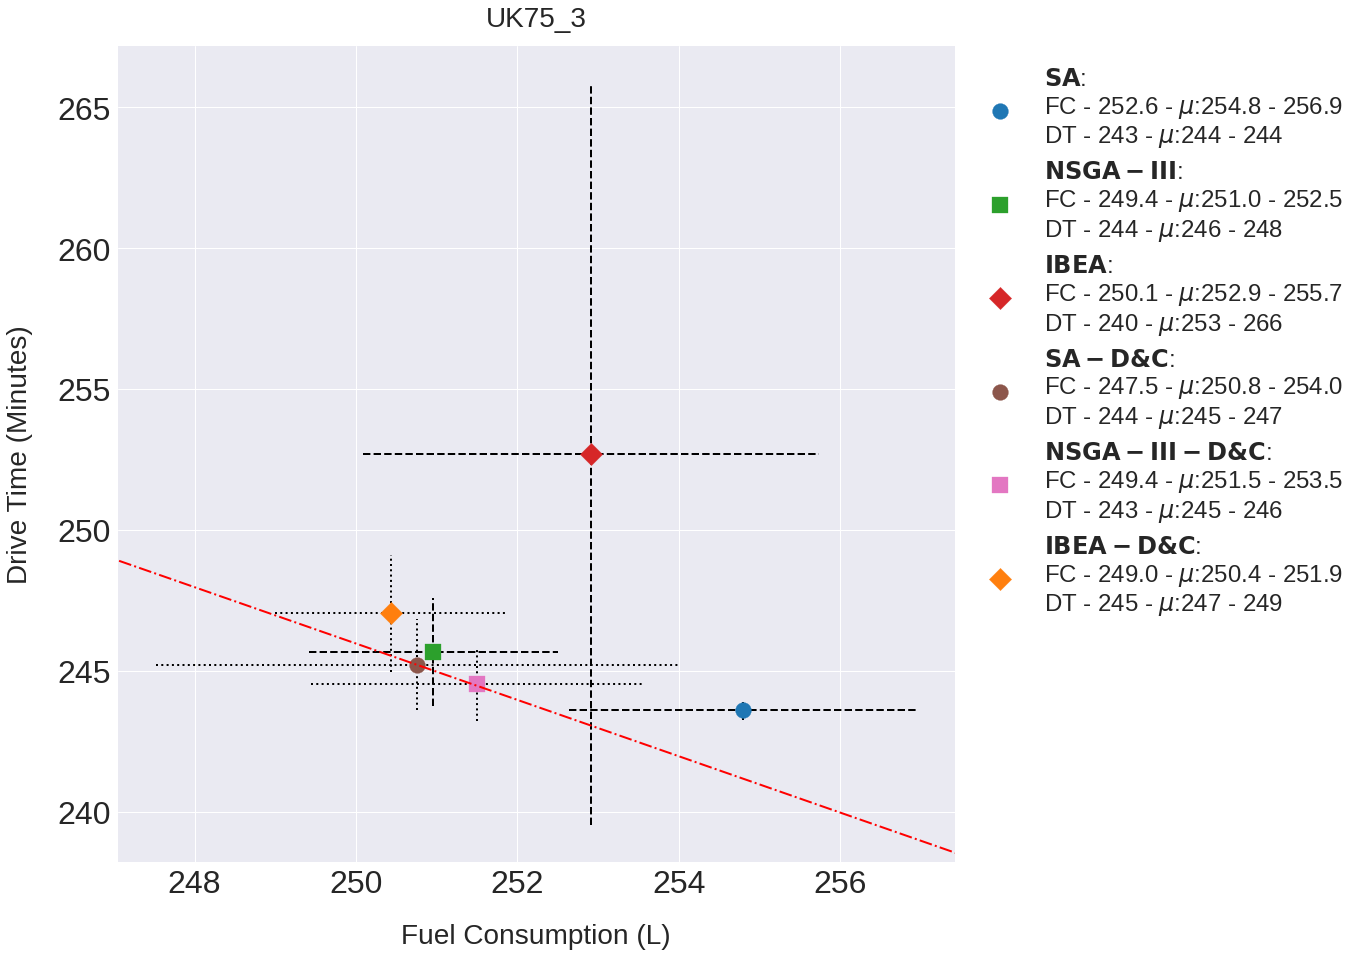

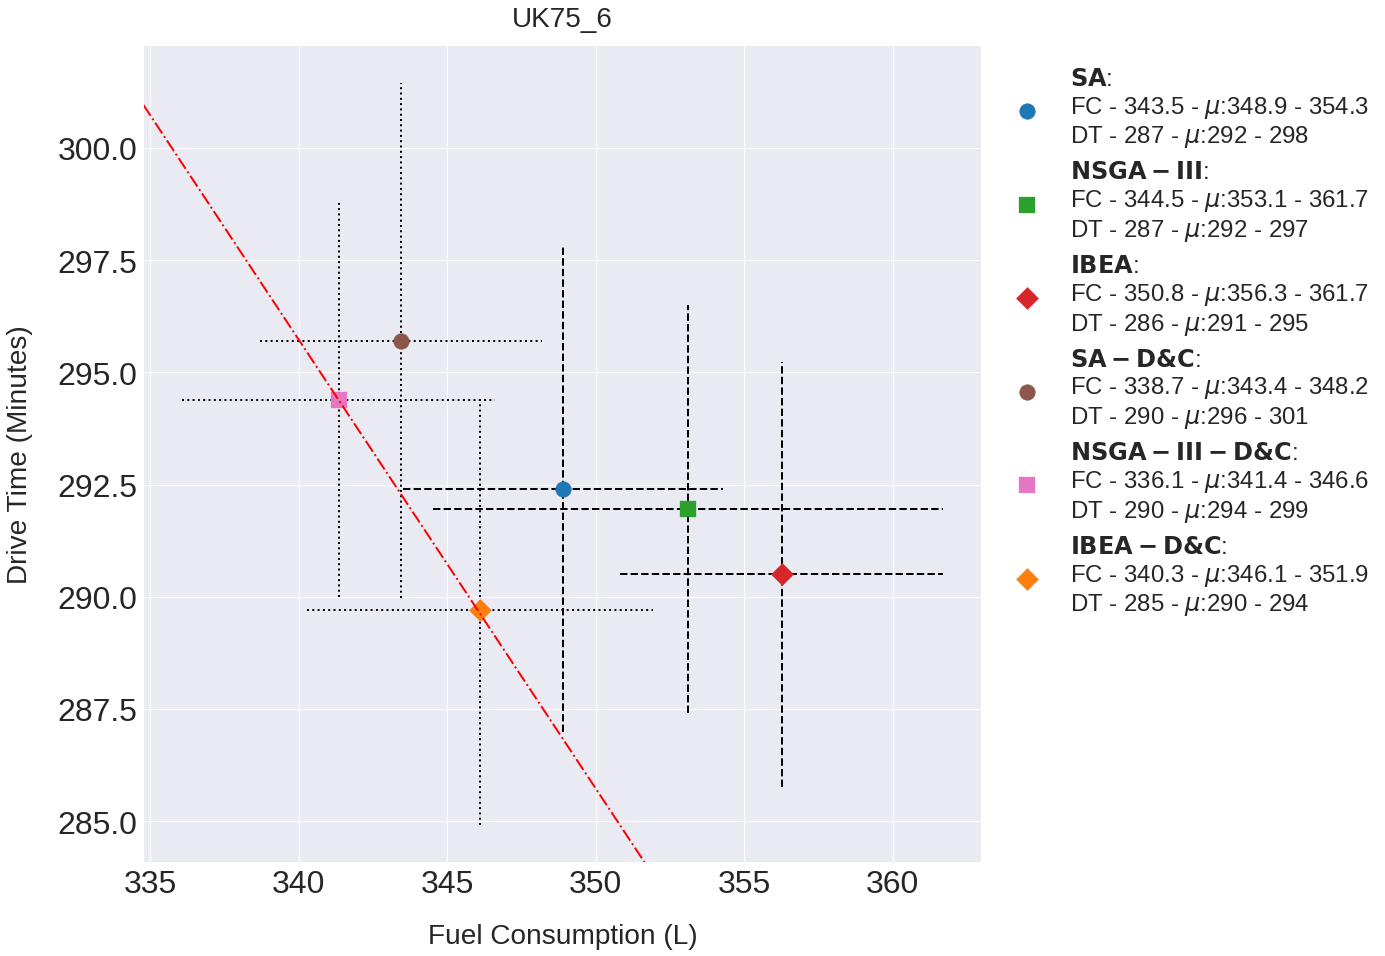

In [32]:
for dataset in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]:
    SA_data_evaluation_limited_unique = combine_datasets("SA", "parameter_data/reruns/", dataset)

    IBEA_data_evaluation_limited_unique = combine_datasets("IBEA", "parameter_data/reruns_L1/", dataset)
    NSGA3_data_evaluation_limited_unique = combine_datasets("NSGA3", "parameter_data/reruns_L1/", dataset)
    
    SA_pickup_and_drop = combine_datasets("SA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    IBEA_pickup_and_drop = combine_datasets("IBEA_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    NSGA3_pickup_and_drop = combine_datasets("NSGAIII_pick_and_drop", "parameter_data/pick_and_drop_results/", dataset)
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    add_minmax_fuel_drivetime_columns(algorithms)
    
    SA_data_evaluation_limited_unique = SA_data_evaluation_limited_unique.mean()
    IBEA_data_evaluation_limited_unique = IBEA_data_evaluation_limited_unique.mean()
    NSGA3_data_evaluation_limited_unique = NSGA3_data_evaluation_limited_unique.mean()
    
    SA_pickup_and_drop = SA_pickup_and_drop.mean()
    IBEA_pickup_and_drop = IBEA_pickup_and_drop.mean()
    NSGA3_pickup_and_drop = NSGA3_pickup_and_drop.mean()
    algorithms = [SA_data_evaluation_limited_unique, NSGA3_data_evaluation_limited_unique,IBEA_data_evaluation_limited_unique,SA_pickup_and_drop,NSGA3_pickup_and_drop,IBEA_pickup_and_drop ]
    
    
    
    labels = ["SA", "NSGA-III","IBEA" ,"SA-D&C", "NSGA-III-D&C","IBEA-D&C" ]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels,minmax_scale=False)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")
    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    #plt.tight_layout(pad=2)
    plt.title(dataset)#[0][:4])
    plt.savefig("2d_plot_fuel_drivetime_pickup_and_drop_{}.pdf".format(dataset),bbox_inches='tight')
    plt.show()

In [29]:
dataset_names = ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]

In [21]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
correlations = []
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")

    algorithms_df = pd.concat([SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset])
    correlations.append([dataset,np.round(algorithms_df[["longest_route_time_final","gini_index"]].reset_index(drop=True).corr().gini_index[0],2)])

# algorithms_df = pd.concat([SA_data_evaluation_limited, GA_data_evaluation_limited, NSGA2_data_evaluation_limited, NSGA3_data_evaluation_limited, UNSGA3_data_evaluation_limited, IBEA_data_evaluation_limited])
# correlations.append(["Overall",np.round(algorithms_df[["longest_route_time_final","gini_index"]].reset_index(drop=True).corr().gini_index[0],2)])


gini_drivetime_corr_df = pd.DataFrame(correlations,columns=["Dataset","Correlation"])
gini_drivetime_corr_df = gini_drivetime_corr_df.transpose()
print(gini_drivetime_corr_df.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
     0 &      1 &      2 &      3 &      4 &      5 &      6 &      7 &      8 \\
\midrule
UK25\_2 & UK25\_4 & UK25\_8 & UK50\_1 & UK50\_2 & UK50\_4 & UK75\_1 & UK75\_3 & UK75\_6 \\
  0.48 &   0.13 &   0.89 &   0.73 &   0.16 &   0.68 &   0.31 &   0.68 &   0.44 \\
\bottomrule
\end{tabular}



In [26]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
correlations = []
for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    
    algorithms_df = pd.concat([SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset])
    correlations.append([dataset,np.round(algorithms_df[["driver_amount","gini_index"]].reset_index(drop=True).corr().gini_index[0],4)])

algorithms_df = pd.concat([SA_data_evaluation_limited, GA_data_evaluation_limited, NSGA2_data_evaluation_limited, NSGA3_data_evaluation_limited, UNSGA3_data_evaluation_limited, IBEA_data_evaluation_limited])
correlations.append(["Overall",np.round(algorithms_df[["driver_amount","gini_index"]].reset_index(drop=True).corr().gini_index[0],4)])


gini_drivetime_corr_df = pd.DataFrame(correlations,columns=["Dataset","Correlation"])
print(gini_drivetime_corr_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Dataset &  Correlation \\
\midrule
 UK25\_2 &      -0.2623 \\
 UK25\_4 &       0.7779 \\
 UK25\_8 &       0.8572 \\
 UK50\_1 &      -0.2410 \\
 UK50\_2 &       0.8208 \\
 UK50\_4 &      -0.3510 \\
 UK75\_1 &       0.2351 \\
 UK75\_3 &      -0.4643 \\
 UK75\_6 &       0.2614 \\
Overall &       0.1235 \\
\bottomrule
\end{tabular}



In [ ]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "NSGA-III", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all")
    
    
    correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_dataset,dataset)),4))
    correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_dataset,dataset)),4))
    correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_dataset,dataset)),4))
    correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_dataset,dataset)),4))
    correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_dataset,dataset)),4))
    correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_dataset,dataset)),4))
    
    
# correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_time_limited)),4))
# correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_time_limited)),4))
# correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_time_limited)),4))
# correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_time_limited)),4))
# correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_time_limited)),4))
# correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_time_limited)),4))    
    

gini_index_df = pd.DataFrame(correlations,index=dataset_names)

print(gini_index_df.to_latex(column_format="lcccccc"))

In [25]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "NSGA-III","IBEA","SA D&C", "NSGA-III D&C","IBEA D&C"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all")
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all")
    
    
    correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_dataset,dataset)),4))
    correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_dataset,dataset)),4))
    correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_dataset,dataset)),4))
    correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_dataset,dataset)),4))
    correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_dataset,dataset)),4))
    correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_dataset,dataset)),4))
    
    
# correlations["SA"].append(np.round(np.median(get_gini_coefficients(SA_data_time_limited)),4))
# correlations["GA"].append(np.round(np.median(get_gini_coefficients(GA_data_time_limited)),4))
# correlations["NSGA-II"].append(np.round(np.median(get_gini_coefficients(NSGA2_data_time_limited)),4))
# correlations["NSGA-III"].append(np.round(np.median(get_gini_coefficients(NSGA3_data_time_limited)),4))
# correlations["UNSGA-III"].append(np.round(np.median(get_gini_coefficients(UNSGA3_data_time_limited)),4))
# correlations["IBEA"].append(np.round(np.median(get_gini_coefficients(IBEA_data_time_limited)),4))    
    

gini_index_df = pd.DataFrame(correlations,index=dataset_names)

print(gini_index_df.to_latex(column_format="lcccccc"))

KeyError: 'GA'

In [19]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "NSGA-III","IBEA","SA D&C", "NSGA-III D&C","IBEA D&C"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    SA_data_dataset_d_c  = SA_pickup_and_drop.where(SA_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")
    NSGA3_data_dataset_d_c = NSGA3_pickup_and_drop.where(NSGA3_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")
    IBEA_data_dataset_d_c = IBEA_pickup_and_drop.where(IBEA_pickup_and_drop.dataset == dataset).dropna(how="all")
    
    correlations["SA"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset,dataset)),4))
    correlations["SA D&C"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset_d_c,dataset)),4))
    
    correlations["NSGA-III"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset,dataset)),4))
    correlations["NSGA-III D&C"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset_d_c,dataset)),4))
    
    correlations["IBEA"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset,dataset)),4))
    correlations["IBEA D&C"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset_d_c,dataset)),4))
    
correlations["SA"].append(np.round(np.mean(get_gini_coefficients(SA_data_dataset)),4))
correlations["SA D&C"].append(np.round(np.mean(get_gini_coefficients(SA_pickup_and_drop)),4))

correlations["NSGA-III"].append(np.round(np.mean(get_gini_coefficients(NSGA3_data_dataset)),4))
correlations["NSGA-III D&C"].append(np.round(np.mean(get_gini_coefficients(NSGA3_pickup_and_drop)),4))

correlations["IBEA"].append(np.round(np.mean(get_gini_coefficients(IBEA_data_dataset)),4))
correlations["IBEA D&C"].append(np.round(np.mean(get_gini_coefficients(IBEA_pickup_and_drop)),4))

gini_index_df = pd.DataFrame(correlations,index=dataset_names+["Overall"])

print(gini_index_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      SA &  NSGA-III &    IBEA &  SA D\&C &  NSGA-III D\&C &  IBEA D\&C \\
\midrule
UK25\_2  &  0.1149 &    0.1194 &  0.1075 &  0.1038 &        0.0998 &    0.1140 \\
UK25\_4  &  0.3146 &    0.2991 &  0.3006 &  0.3109 &        0.3050 &    0.3071 \\
UK25\_8  &  0.2061 &    0.1953 &  0.1998 &  0.1893 &        0.2092 &    0.2007 \\
UK50\_1  &  0.1183 &    0.1286 &  0.1035 &  0.1113 &        0.1084 &    0.1023 \\
UK50\_2  &  0.1775 &    0.1735 &  0.1711 &  0.1718 &        0.1604 &    0.1574 \\
UK50\_4  &  0.1603 &    0.1600 &  0.1541 &  0.1627 &        0.1540 &    0.1585 \\
UK75\_1  &  0.2503 &    0.2404 &  0.2446 &  0.2636 &        0.2551 &    0.2509 \\
UK75\_3  &  0.2223 &    0.2227 &  0.2244 &  0.2164 &        0.2230 &    0.2241 \\
UK75\_6  &  0.2037 &    0.2024 &  0.1949 &  0.2105 &        0.2160 &    0.2066 \\
Overall &  0.2037 &    0.2024 &  0.1949 &  0.1934 &        0.1923 &    0.1913 \\
\bottomrule
\end{tabular}



In [36]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
dataset_names_latex =  ["UK25\_2", "UK25\_4", "UK25\_8", "UK50\_1", "UK50\_2", "UK50\_4", "UK75\_1","UK75\_3","UK75\_6"]
algorithm_names = ["SA", "NSGA-III","IBEA","SA D\&C", "NSGA-III D\&C","IBEA D\&C"]
correlations = {algo_name:[] for algo_name in algorithm_names}
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return np.round((mean_val-min_val),2)

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    SA_data_dataset_d_c  = SA_pickup_and_drop.where(SA_pickup_and_drop.dataset == dataset).dropna(how="all").mean()
    
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset_d_c = NSGA3_pickup_and_drop.where(NSGA3_pickup_and_drop.dataset == dataset).dropna(how="all").mean()
    
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset_d_c = IBEA_pickup_and_drop.where(IBEA_pickup_and_drop.dataset == dataset).dropna(how="all").mean()

    format_string = "{} $\pm$ {}"
    
    
    dataframes = [SA_data_dataset,NSGA3_data_dataset,IBEA_data_dataset,SA_data_dataset_d_c,NSGA3_data_dataset_d_c,IBEA_data_dataset_d_c]
    
    
    for algorithm_name,dataframe in zip(algorithm_names,dataframes):
           correlations[algorithm_name].append(format_string.format(np.round(dataframe.gini_mean,2),calc_interval(dataframe.gini_mean,dataframe.gini_min)))

            
    
first = pd.DataFrame([correlations["SA"],correlations["NSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["SA D\&C"],correlations["NSGA-III D\&C"],correlations["IBEA D\&C"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])


\begin{tabular}{lccc}
\toprule
{} &               SA &         NSGA-III &             IBEA \\
\midrule
UK25\_2 &  0.11 $\pm$ 0.02 &  0.12 $\pm$ 0.01 &  0.11 $\pm$ 0.01 \\
UK25\_4 &  0.31 $\pm$ 0.01 &   0.3 $\pm$ 0.01 &   0.3 $\pm$ 0.01 \\
UK25\_8 &  0.21 $\pm$ 0.01 &   0.2 $\pm$ 0.02 &   0.2 $\pm$ 0.02 \\
UK50\_1 &  0.12 $\pm$ 0.01 &  0.13 $\pm$ 0.02 &    0.1 $\pm$ 0.0 \\
UK50\_2 &  0.18 $\pm$ 0.01 &  0.17 $\pm$ 0.02 &  0.17 $\pm$ 0.02 \\
UK50\_4 &  0.16 $\pm$ 0.01 &  0.16 $\pm$ 0.01 &   0.15 $\pm$ 0.0 \\
UK75\_1 &  0.25 $\pm$ 0.01 &  0.24 $\pm$ 0.02 &  0.24 $\pm$ 0.01 \\
UK75\_3 &  0.22 $\pm$ 0.01 &   0.22 $\pm$ 0.0 &  0.22 $\pm$ 0.01 \\
UK75\_6 &   0.2 $\pm$ 0.01 &   0.2 $\pm$ 0.01 &  0.19 $\pm$ 0.01 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &          SA D\&C &    NSGA-III D\&C &        IBEA D\&C \\
\midrule
UK25\_2 &   0.1 $\pm$ 0.02 &   0.1 $\pm$ 0.01 &  0.11 $\pm$ 0.01 \\
UK25\_4 &  0.31 $\pm$ 0.02 &  0.31 $\pm$ 0.01 &  0.31 $\pm$ 0.01 \\
UK25\_8 &  0.19 $\p

In [105]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA","IBEA3"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_third_objective_dataset = IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == dataset).dropna(how="all").mean()
    
    
    
    correlations["SA"].append(np.round(SA_data_dataset.total_drive_time/60,1))
    correlations["GA"].append(np.round(GA_data_dataset.total_drive_time/60,1))
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.total_drive_time/60,1))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.total_drive_time/60,1))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.total_drive_time/60,1))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.total_drive_time/60,1))
    correlations["IBEA3"].append(np.round(IBEA_data_third_objective_dataset.total_drive_time/60,1))

result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'
print(result_df.to_latex(column_format="lccccccc",escape=False))
#print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))

\begin{tabular}{lccccccc}
\toprule
{} &    SA &    GA &  NSGA-II &  NSGA-III &  UNSGA-III &  IBEA &  IBEA3 \\
\midrule
UK25\_2 &  10.9 &  10.8 &     10.9 &      10.9 &       11.0 &  10.7 &    9.1 \\
UK25\_4 &  20.5 &  20.3 &     20.3 &      20.3 &       20.9 &  20.2 &   19.8 \\
UK25\_8 &  14.2 &  14.2 &     14.3 &      14.3 &       14.4 &  14.3 &   13.8 \\
UK50\_1 &  30.1 &  29.2 &     29.5 &      29.2 &       29.7 &  28.9 &   27.9 \\
UK50\_2 &  25.2 &  24.9 &     25.5 &      25.1 &       25.3 &  24.9 &   24.0 \\
UK50\_4 &  25.4 &  25.2 &     25.4 &      25.2 &       25.4 &  25.4 &   24.2 \\
UK75\_1 &  50.1 &  48.5 &     50.3 &      51.0 &       51.0 &  50.2 &   49.3 \\
UK75\_3 &  38.1 &  37.9 &     37.4 &      37.4 &       37.9 &  37.7 &   36.1 \\
UK75\_6 &  42.1 &  41.4 &     41.2 &      41.8 &       41.8 &  42.3 &   40.4 \\
\bottomrule
\end{tabular}



In [23]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA","IBEA3"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_third_objective_dataset = IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == dataset).dropna(how="all").mean()
    
    
    
    correlations["SA"].append(np.round(SA_data_dataset.gini_mean,2))
    correlations["GA"].append(np.round(GA_data_dataset.gini_mean,2))
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.gini_mean,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.gini_mean,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.gini_mean,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.gini_mean,2))
    correlations["IBEA3"].append(np.round(IBEA_data_third_objective_dataset.gini_mean,2))
#     correlations["SA"].append(np.round(SA_data_dataset.distance_to_origin,4))
#     correlations["GA"].append(np.round(GA_data_dataset.distance_to_origin,4))
#     correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.distance_to_origin,4))
#     correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.distance_to_origin,4))
#     correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.distance_to_origin,4))
#     correlations["IBEA"].append(np.round(IBEA_data_dataset.distance_to_origin,4))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))

\begin{tabular}{lccccccc}
\toprule
{} &            SA &            GA &       NSGA-II &      NSGA-III &     UNSGA-III &          IBEA &         IBEA3 \\
\midrule
UK25\_2 & \textbf{0.11} &          0.12 & \textbf{0.11} &          0.12 &          0.10 &          0.18 & \textbf{0.05} \\
UK25\_4 &          0.31 &          0.30 &          0.29 &          0.30 &          0.30 & \textbf{0.27} &          0.29 \\
UK25\_8 &          0.21 & \textbf{0.22} &          0.21 &          0.20 &          0.19 & \textbf{0.04} &          0.07 \\
UK50\_1 &          0.12 &          0.12 & \textbf{0.11} &          0.13 & \textbf{0.11} &          0.12 & \textbf{0.16} \\
UK50\_2 &          0.18 &          0.17 &          0.17 &          0.17 &          0.17 & \textbf{0.06} & \textbf{0.06} \\
UK50\_4 & \textbf{0.16} & \textbf{0.16} & \textbf{0.16} & \textbf{0.16} & \textbf{0.16} &          0.17 &          0.17 \\
UK75\_1 &          0.25 &          0.26 &          0.25 &          0.24 &          0.25 & \textbf{0.

In [68]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA","IBEA3"]#,"UNSGA-III",
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return np.round((mean_val-min_val),2)

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
   
    IBEA_data_third_objective_dataset = IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == dataset).dropna(how="all").mean()
    
    format_string = "{} $\pm$ {}"
    
    
    correlations["SA"].append(format_string.format(np.round(SA_data_dataset.fuel_consumption_final,2),
                                                   calc_interval(SA_data_dataset.fuel_consumption_final,SA_data_dataset.fuel_consumption_final_min)))
    correlations["IBEA3"].append(format_string.format(np.round(IBEA_data_third_objective_dataset.gini_index,2),
                                                      calc_interval(IBEA_data_third_objective_dataset.gini_index,IBEA_data_third_objective_dataset.gini_min)))
    

first = pd.DataFrame([correlations["SA"],correlations["IBEA3"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
print(first.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                 SA &            IBEA3 \\
\midrule
UK25\_2 &   88.89 $\pm$ 2.56 &  0.05 $\pm$ 0.01 \\
UK25\_4 &   244.6 $\pm$ 2.73 &   0.29 $\pm$ 0.0 \\
UK25\_8 &  106.05 $\pm$ 2.74 &  0.07 $\pm$ 0.01 \\
UK50\_1 &  230.68 $\pm$ 5.14 &  0.16 $\pm$ 0.01 \\
UK50\_2 &  179.83 $\pm$ 2.82 &  0.06 $\pm$ 0.01 \\
UK50\_4 &   186.3 $\pm$ 2.72 &   0.17 $\pm$ 0.0 \\
UK75\_1 &  438.04 $\pm$ 8.17 &  0.21 $\pm$ 0.01 \\
UK75\_3 &  254.79 $\pm$ 2.15 &  0.26 $\pm$ 0.01 \\
UK75\_6 &    348.9 $\pm$ 5.4 &  0.17 $\pm$ 0.01 \\
\bottomrule
\end{tabular}



In [17]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names =  ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return np.round((mean_val-min_val),1)

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    
    format_string = "{} $\pm$ {}"
    
    
    correlations["SA"].append(format_string.format(np.round(SA_data_dataset.objective_sum,1),calc_interval(SA_data_dataset.objective_sum,SA_data_dataset.objective_sum_min)))
    correlations["GA"].append(format_string.format(np.round(GA_data_dataset.objective_sum,1),calc_interval(GA_data_dataset.objective_sum,GA_data_dataset.objective_sum_min)))
    correlations["NSGA-II"].append(format_string.format(np.round(NSGA2_data_dataset.objective_sum,1),calc_interval(NSGA2_data_dataset.objective_sum,NSGA2_data_dataset.objective_sum_min)))
    correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.objective_sum,1),calc_interval(NSGA3_data_dataset.objective_sum,NSGA3_data_dataset.objective_sum_min)))
    correlations["UNSGA-III"].append(format_string.format(np.round(UNSGA3_data_dataset.objective_sum,1),calc_interval(UNSGA3_data_dataset.objective_sum,UNSGA3_data_dataset.objective_sum_min)))
    correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.objective_sum,1),calc_interval(IBEA_data_dataset.objective_sum,IBEA_data_dataset.objective_sum_min)))
    
    
    
    #result_df = pd.DataFrame(correlations,index=dataset_names_latex)

#min_pandas = result_df.min(1)

# def f_tex(x):
#     if x in min_pandas.values:
#         return '\\textbf{' +f'{x:0.4f}'+ '}'
#     else:
#         return f'{x:0.4f}'

first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                SA &               GA &           NSGA-II \\
\midrule
UK25\_2 &   224.1 $\pm$ 2.6 &  226.2 $\pm$ 3.5 &   220.2 $\pm$ 1.5 \\
UK25\_4 &   608.5 $\pm$ 1.9 &  618.0 $\pm$ 3.3 &   610.7 $\pm$ 2.3 \\
UK25\_8 &   341.6 $\pm$ 0.4 &  342.3 $\pm$ 0.5 &   342.0 $\pm$ 0.5 \\
UK50\_1 &   449.4 $\pm$ 9.2 &  435.0 $\pm$ 5.1 &   442.5 $\pm$ 7.1 \\
UK50\_2 &   413.9 $\pm$ 5.5 &  414.4 $\pm$ 3.8 &   431.9 $\pm$ 4.4 \\
UK50\_4 &   408.1 $\pm$ 1.7 &  408.2 $\pm$ 1.2 &   410.9 $\pm$ 1.7 \\
UK75\_1 &  917.7 $\pm$ 11.9 &  914.6 $\pm$ 9.2 &  972.9 $\pm$ 14.6 \\
UK75\_3 &   509.6 $\pm$ 4.3 &  511.6 $\pm$ 4.2 &   521.6 $\pm$ 4.0 \\
UK75\_6 &   673.6 $\pm$ 7.6 &  662.1 $\pm$ 8.2 &   675.5 $\pm$ 8.9 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &          NSGA-III &         UNSGA-III &               IBEA \\
\midrule
UK25\_2 &   223.3 $\pm$ 1.4 &   226.2 $\pm$ 2.0 &    222.7 $\pm$ 2.1 \\
UK25\_4 &   609.4 $\pm$ 2.5 &   615.6 $\pm$ 2.3 &    608.9 

In [63]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names =  ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return np.round((mean_val-min_val),2)

for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    
    format_string = "{} $\pm$ {}"
    
    
    dataframes = [SA_data_dataset,GA_data_dataset,NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]
    
    
    for algorithm_name,dataframe in zip(algorithm_names,dataframes):
         correlations[algorithm_name].append(format_string.format(np.round(dataframe.gini_index,2),calc_interval(dataframe.gini_index,dataframe.gini_min)))

            
first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &               SA &               GA &          NSGA-II \\
\midrule
UK25\_2 &  0.11 $\pm$ 0.02 &  0.12 $\pm$ 0.02 &  0.11 $\pm$ 0.01 \\
UK25\_4 &  0.31 $\pm$ 0.01 &   0.3 $\pm$ 0.01 &  0.29 $\pm$ 0.01 \\
UK25\_8 &  0.21 $\pm$ 0.01 &   0.22 $\pm$ 0.0 &  0.21 $\pm$ 0.01 \\
UK50\_1 &  0.12 $\pm$ 0.01 &  0.12 $\pm$ 0.01 &  0.11 $\pm$ 0.01 \\
UK50\_2 &  0.18 $\pm$ 0.01 &  0.17 $\pm$ 0.01 &  0.17 $\pm$ 0.02 \\
UK50\_4 &  0.16 $\pm$ 0.01 &   0.16 $\pm$ 0.0 &   0.16 $\pm$ 0.0 \\
UK75\_1 &  0.25 $\pm$ 0.01 &  0.26 $\pm$ 0.01 &  0.25 $\pm$ 0.01 \\
UK75\_3 &  0.22 $\pm$ 0.01 &  0.22 $\pm$ 0.01 &   0.22 $\pm$ 0.0 \\
UK75\_6 &   0.2 $\pm$ 0.01 &  0.21 $\pm$ 0.01 &  0.21 $\pm$ 0.01 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &         NSGA-III &        UNSGA-III &             IBEA \\
\midrule
UK25\_2 &  0.12 $\pm$ 0.01 &   0.1 $\pm$ 0.02 &  0.11 $\pm$ 0.01 \\
UK25\_4 &   0.3 $\pm$ 0.01 &   0.3 $\pm$ 0.01 &   0.3 $\pm$ 0.01 \\
UK25\_8 &   0.2 $\p

348.90251779767567

In [29]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names =  ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return np.round((mean_val-min_val),1)

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    
    format_string = "{} $\pm$ {}"
    
    
    correlations["SA"].append(format_string.format(np.round(SA_data_dataset.fuel_consumption_final,1),calc_interval(SA_data_dataset.fuel_consumption_final,SA_data_dataset.fuel_consumption_final_min)))
    correlations["GA"].append(format_string.format(np.round(GA_data_dataset.fuel_consumption_final,1),calc_interval(GA_data_dataset.fuel_consumption_final,GA_data_dataset.fuel_consumption_final_min)))
    correlations["NSGA-II"].append(format_string.format(np.round(NSGA2_data_dataset.fuel_consumption_final,1),calc_interval(NSGA2_data_dataset.fuel_consumption_final,NSGA2_data_dataset.fuel_consumption_final_min)))
    correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.fuel_consumption_final,1),calc_interval(NSGA3_data_dataset.fuel_consumption_final,NSGA3_data_dataset.fuel_consumption_final_min)))
    correlations["UNSGA-III"].append(format_string.format(np.round(UNSGA3_data_dataset.fuel_consumption_final,1),calc_interval(UNSGA3_data_dataset.fuel_consumption_final,UNSGA3_data_dataset.fuel_consumption_final_min)))
    correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.fuel_consumption_final,1),calc_interval(IBEA_data_dataset.fuel_consumption_final,IBEA_data_dataset.fuel_consumption_final_min)))
    
    
    
    #result_df = pd.DataFrame(correlations,index=dataset_names_latex)

#min_pandas = result_df.min(1)

# def f_tex(x):
#     if x in min_pandas.values:
#         return '\\textbf{' +f'{x:0.4f}'+ '}'
#     else:
#         return f'{x:0.4f}'

first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                SA &               GA &           NSGA-II \\
\midrule
UK25\_2 &    87.6 $\pm$ 1.8 &   87.6 $\pm$ 2.1 &    88.4 $\pm$ 1.1 \\
UK25\_4 &   244.2 $\pm$ 2.6 &  247.6 $\pm$ 4.0 &   243.3 $\pm$ 2.4 \\
UK25\_8 &   110.2 $\pm$ 4.6 &  104.2 $\pm$ 0.5 &   110.3 $\pm$ 4.3 \\
UK50\_1 &   225.6 $\pm$ 4.3 &  220.0 $\pm$ 3.5 &   224.3 $\pm$ 3.4 \\
UK50\_2 &   179.2 $\pm$ 3.9 &  179.2 $\pm$ 2.3 &   190.3 $\pm$ 3.7 \\
UK50\_4 &   186.2 $\pm$ 2.0 &  185.5 $\pm$ 2.4 &   187.8 $\pm$ 2.6 \\
UK75\_1 &  473.0 $\pm$ 11.0 &  463.7 $\pm$ 8.9 &  516.8 $\pm$ 12.9 \\
UK75\_3 &   263.3 $\pm$ 4.9 &  263.0 $\pm$ 3.6 &   265.0 $\pm$ 3.9 \\
UK75\_6 &   368.9 $\pm$ 7.2 &  359.9 $\pm$ 7.0 &   364.1 $\pm$ 8.2 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &          NSGA-III &         UNSGA-III &              IBEA \\
\midrule
UK25\_2 &    90.7 $\pm$ 1.8 &    90.3 $\pm$ 2.2 &    87.0 $\pm$ 1.4 \\
UK25\_4 &   244.4 $\pm$ 3.2 &   252.2 $\pm$ 2.7 &   243.1 $\p

In [45]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names =  ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)

def calc_interval(mean_val,min_val):
    return int(np.round((mean_val-min_val),0))

for dataset in dataset_names:
    SA_data_dataset = SA_data_time_limited.where(SA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_time_limited.where(GA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_time_limited.where(NSGA2_data_time_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_time_limited.where(NSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_time_limited.where(UNSGA3_data_time_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_time_limited.where(IBEA_data_time_limited.dataset == dataset).dropna(how="all").mean()
    
    format_string = "{} $\pm$ {}"
    
    
    dataframes = [SA_data_dataset,GA_data_dataset,NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]
    
    
    for algorithm_name,dataframe in zip(algorithm_names,dataframes):
           correlations[algorithm_name].append(format_string.format(int(np.round(dataframe.longest_route_time_final,0)),calc_interval(dataframe.longest_route_time_final,dataframe.longest_route_time_final_min)))

            
first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &           SA &           GA &      NSGA-II \\
\midrule
UK25\_2 &  137 $\pm$ 3 &  139 $\pm$ 4 &  132 $\pm$ 2 \\
UK25\_4 &  364 $\pm$ 1 &  370 $\pm$ 4 &  367 $\pm$ 2 \\
UK25\_8 &  231 $\pm$ 5 &  238 $\pm$ 0 &  232 $\pm$ 4 \\
UK50\_1 &  224 $\pm$ 8 &  215 $\pm$ 3 &  218 $\pm$ 5 \\
UK50\_2 &  235 $\pm$ 4 &  235 $\pm$ 3 &  242 $\pm$ 4 \\
UK50\_4 &  222 $\pm$ 2 &  223 $\pm$ 3 &  223 $\pm$ 3 \\
UK75\_1 &  445 $\pm$ 4 &  451 $\pm$ 5 &  456 $\pm$ 4 \\
UK75\_3 &  246 $\pm$ 2 &  249 $\pm$ 3 &  257 $\pm$ 5 \\
UK75\_6 &  305 $\pm$ 6 &  302 $\pm$ 7 &  311 $\pm$ 7 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &      NSGA-III &    UNSGA-III &         IBEA \\
\midrule
UK25\_2 &   133 $\pm$ 2 &  136 $\pm$ 3 &  136 $\pm$ 3 \\
UK25\_4 &   365 $\pm$ 2 &  363 $\pm$ 2 &  366 $\pm$ 2 \\
UK25\_8 &   229 $\pm$ 5 &  227 $\pm$ 5 &  231 $\pm$ 5 \\
UK50\_1 &  224 $\pm$ 11 &  220 $\pm$ 4 &  216 $\pm$ 3 \\
UK50\_2 &   246 $\pm$ 7 &  245 $\pm$ 9 &  237 $\pm$ 3 \\
U

In [122]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = ["SA", "GA", "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}
dataset_names_latex = [name[:-2] + "\\" + name[-2:] for name in dataset_names]
def calc_percentage(mean_val,min_val):
    return np.round(((mean_val-min_val)/mean_val)*100,2)


for dataset in dataset_names:
    SA_data_dataset = SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    GA_data_dataset = GA_data_evaluation_limited.where(GA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all")#.mean()
    
    dataframes = [SA_data_dataset,GA_data_dataset,NSGA2_data_dataset,NSGA3_data_dataset,UNSGA3_data_dataset,IBEA_data_dataset]
    
    
    format_string = "{} $\pm$ {}\%"
    for algorithm_name,dataframe in zip(algorithm_names,dataframes):
           correlations[algorithm_name].append(format_string.format(np.round(dataframe.gini_mean[0],3),calc_percentage(dataframe.gini_mean[0],dataframe.gini_min[0])))
        
        
         
    
#     correlations["SA"].append(format_string.format(np.round(SA_data_dataset.longest_route_time_final,2),calc_percentage(SA_data_dataset.longest_route_time_final,SA_data_dataset.longest_route_time_final_min)))
#     correlations["GA"].append(format_string.format(np.round(GA_data_dataset.longest_route_time_final,2),calc_percentage(GA_data_dataset.longest_route_time_final,GA_data_dataset.longest_route_time_final_min)))
#     correlations["NSGA-II"].append(format_string.format(np.round(NSGA2_data_dataset.longest_route_time_final,2),calc_percentage(NSGA2_data_dataset.longest_route_time_final,NSGA2_data_dataset.longest_route_time_final_min)))
#     correlations["NSGA-III"].append(format_string.format(np.round(NSGA3_data_dataset.longest_route_time_final,2),calc_percentage(NSGA3_data_dataset.longest_route_time_final,NSGA3_data_dataset.longest_route_time_final_min)))
#     correlations["UNSGA-III"].append(format_string.format(np.round(UNSGA3_data_dataset.longest_route_time_final,2),calc_percentage(UNSGA3_data_dataset.longest_route_time_final,UNSGA3_data_dataset.longest_route_time_final_min)))
#     correlations["IBEA"].append(format_string.format(np.round(IBEA_data_dataset.longest_route_time_final,2),calc_percentage(IBEA_data_dataset.longest_route_time_final,IBEA_data_dataset.longest_route_time_final_min)))
# result_df = pd.DataFrame(correlations,index=dataset_names_latex)

first = pd.DataFrame([correlations["SA"],correlations["GA"],correlations["NSGA-II"]],columns=dataset_names_latex,index=algorithm_names[:3]).T
second =  pd.DataFrame([correlations["NSGA-III"],correlations["UNSGA-III"],correlations["IBEA"]],columns=dataset_names_latex,index=algorithm_names[3:]).T
print(first.to_latex(escape=False,column_format="lccc"))
print(second.to_latex(escape=False,column_format="lccc"))

\begin{tabular}{lccc}
\toprule
{} &                   SA &                   GA &              NSGA-II \\
\midrule
UK25\_2 &  0.115 $\pm$ 16.89\% &  0.125 $\pm$ 17.59\% &  0.112 $\pm$ 11.28\% \\
UK25\_4 &   0.315 $\pm$ 3.91\% &   0.296 $\pm$ 4.11\% &    0.292 $\pm$ 4.5\% \\
UK25\_8 &    0.206 $\pm$ 7.1\% &   0.216 $\pm$ 0.29\% &   0.206 $\pm$ 7.04\% \\
UK50\_1 &   0.118 $\pm$ 8.07\% &     0.12 $\pm$ 8.4\% &   0.108 $\pm$ 5.69\% \\
UK50\_2 &   0.177 $\pm$ 7.98\% &   0.172 $\pm$ 8.62\% &   0.171 $\pm$ 8.99\% \\
UK50\_4 &    0.16 $\pm$ 4.26\% &   0.156 $\pm$ 3.15\% &   0.158 $\pm$ 2.04\% \\
UK75\_1 &    0.25 $\pm$ 4.51\% &   0.262 $\pm$ 5.09\% &    0.25 $\pm$ 5.93\% \\
UK75\_3 &   0.222 $\pm$ 2.53\% &   0.219 $\pm$ 2.87\% &   0.224 $\pm$ 1.63\% \\
UK75\_6 &   0.204 $\pm$ 5.72\% &    0.207 $\pm$ 5.2\% &   0.206 $\pm$ 3.59\% \\
\bottomrule
\end{tabular}

\begin{tabular}{lccc}
\toprule
{} &             NSGA-III &            UNSGA-III &                 IBEA \\
\midrule
UK25\_2 &  0.119 $\pm$ 

In [24]:
def strip_last_two(x):
    return x[:-2]
IBEA_data_evaluation_limited["dataset_stripped"]  = IBEA_data_evaluation_limited.dataset.apply(strip_last_two)
SA_data_evaluation_limited["dataset_stripped"]  = SA_data_evaluation_limited.dataset.apply(strip_last_two)

In [28]:
print("IBEA:",IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset_stripped == "UK25").dropna(how="all").computation_times_final.mean(),"\nSA: ",SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset_stripped == "UK25").dropna(how="all").computation_times_final.mean())

IBEA: 1.3481044504377577 
SA:  0.28744602468278674


In [29]:
print("IBEA:",IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset_stripped == "UK50").dropna(how="all").computation_times_final.mean(),"\nSA: ",SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset_stripped == "UK50").dropna(how="all").computation_times_final.mean())

IBEA: 2.841034738222758 
SA:  1.4909102466371325


In [30]:
print("IBEA:",IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset_stripped == "UK75").dropna(how="all").computation_times_final.mean(),"\nSA: ",SA_data_evaluation_limited.where(SA_data_evaluation_limited.dataset_stripped == "UK75").dropna(how="all").computation_times_final.mean())

IBEA: 7.53415735827552 
SA:  5.6300458563698665


In [13]:
IBEA_data_third_objective.where(IBEA_data_third_objective.dataset =="UK25_2").dropna(how="all")[""]

Unnamed: 0                                            fitness  \
0          0.0  [[91.6397840602681, 11.470555555555556, 20.777...   
1          1.0  [[95.49557967099543, 11.155833333333334, 32.78...   
2          2.0  [[81.54071622794748, 9.982777777777779, 37.354...   
3          3.0  [[84.03064321854187, 10.313888888888888, 25.13...   
4          4.0  [[80.79546232974545, 10.128333333333334, 34.79...   
5          5.0  [[84.74042721949172, 10.865, 30.07789197388829...   
6          6.0  [[119.08232245910843, 12.966111111111111, 10.1...   
7          7.0  [[85.69696653866761, 10.751388888888888, 24.16...   
8          8.0  [[97.51812090098059, 11.725, 16.13756613756613...   
9          9.0  [[81.00586531428158, 10.3475, 24.9034925236906...   
10        10.0  [[89.8687325642022, 10.566666666666666, 34.213...   
11        11.0  [[83.05667165018214, 10.096111111111112, 27.58...   
12        12.0  [[98.97738054716366, 11.521666666666667, 23.98...   
13        13.0  [[90.98852149383606, 10.355, 31.87939267128064...   
14        14.0  [[86.47141927823131, 10.544722222222223, 19.06...   
15        15.0  [[94.45361806546238, 11.396666666666667, 38.07...   
16        16.0  [[114.84595974461185, 12.354722222222222, 24.4...   
17        17.0  [[93.2479973292136, 11.332777777777778, 32.319...   
18        18.0  [[81.52860382495682, 10.609444444444444, 26.05...   
19        19.0  [[94.15195115243765, 11.024722222222222, 17.62...   
20        20.0  [[91.38951878463897, 10.829166666666667, 26.13...   
21        21.0  [[77.8055743233231, 10.046944444444444, 34.470...   
22        22.0  [[98.4343181485974, 11.075555555555555, 26.274...   
23        23.0  [[96.12722900268236, 11.261944444444444, 23.43...   
24        24.0  [[84.03064321854187, 10.313888888888888, 25.13...   
25        25.0  [[82.92411739330409, 10.57611111111111, 30.136...   
26        26.0  [[88.2957576067705, 11.165, 24.227496641289743...   
27        27.0  [[83.61706835654104, 10.751388888888888, 24.16...   
28        28.0  [[81.65927520327865, 10.148055555555555, 34.80...   
29        29.0  [[100.18779654899363, 11.677222222222222, 21.0...   

              route_distance  \
0   [145666, 170199, 123079]   
1   [138533, 172488, 143262]   
2   [145666, 168298, 116334]   
3   [122371, 183305, 118466]   
4   [138533, 168018, 131062]   
5   [138533, 168298, 124784]   
6   [138533, 170199, 135370]   
7   [138533, 172770, 141416]   
8   [138533, 168018, 121451]   
9   [138533, 168298, 128122]   
10  [138533, 168298, 120905]   
11  [138533, 168298, 110865]   
12  [138533, 168018, 121451]   
13  [138533, 168018, 137182]   
14  [138533, 168018, 120025]   
15  [138533, 170199, 135370]   
16  [138533, 193547, 134745]   
17  [138533, 168298, 122450]   
18  [122371, 183305, 118466]   
19  [145666, 168298, 124784]   
20   [122371, 184933, 98083]   
21  [138533, 176810, 114789]   
22  [145666, 168298, 128122]   
23  [145666, 168298, 128122]   
24  [138533, 168298, 124159]   
25  [138533, 168018, 133742]   
26  [122371, 174570, 136531]   
27  [145666, 168298, 128122]   
28  [138533, 170199, 140637]   
29  [122371, 174570, 121451]   

                                     fuel_consumption  \
0   [91.6397840602681, 89.82347423408046, 87.75585...   
1   [95.49557967099543, 99.79296968267563, 93.8181...   
2   [81.54071622794748, 79.31541017017665, 74.8643...   
3   [84.03064321854187, 77.1187295927937, 72.06508...   
4   [80.79546232974545, 79.97886108218378, 84.7436...   
5   [84.74042721949172, 79.38345535700235, 79.3834...   
6   [119.08232245910843, 96.65585022641591, 81.964...   
7   [85.69696653866761, 80.50555521849914, 82.0973...   
8   [97.51812090098059, 83.49792027842778, 81.5812...   
9   [81.00586531428158, 80.32026809384828, 80.2154...   
10  [89.8687325642022, 105.40063951380266, 77.8319...   
11  [83.05667165018214, 84.7632776076064, 84.76327...   
12  [98.97738054716366, 79.25353383465415, 72.0886...   
13  [90.98852149383606, 82.86780686606113, 80.4646...   
14  [86.47141927